# Bank Data Analysis

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
plt.style.use("Solarize_Light2")

## Loading Dataset

In [60]:
df = pd.read_csv("./bank-full.csv", delimiter=";")
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [61]:
from sklearn.preprocessing import LabelBinarizer

X = df.drop("y", axis=1)
y = df.loc[:, "y"]

lb = LabelBinarizer()
y_encoded = lb.fit_transform(y)

y_encoded

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [62]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.1, random_state=42)

## Features Analysis & Engineering

In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40689 entries, 14565 to 15795
Data columns (total 16 columns):
age          40689 non-null int64
job          40689 non-null object
marital      40689 non-null object
education    40689 non-null object
default      40689 non-null object
balance      40689 non-null int64
housing      40689 non-null object
loan         40689 non-null object
contact      40689 non-null object
day          40689 non-null int64
month        40689 non-null object
duration     40689 non-null int64
campaign     40689 non-null int64
pdays        40689 non-null int64
previous     40689 non-null int64
poutcome     40689 non-null object
dtypes: int64(7), object(9)
memory usage: 5.3+ MB


In [7]:
features = X_train.columns

for col in features:
    print(col)
    unique = X_train.loc[:, col].unique()
    if len(unique) < 100:
        print(unique)
    print()

age
[29 57 54 52 34 50 40 43 59 53 35 49 32 28 56 27 39 58 60 41 51 30 33 36
 46 31 42 44 48 26 55 25 80 47 23 37 45 38 68 20 79 67 65 64 22 62 73 24
 61 21 70 74 82 75 71 76 77 66 86 18 69 83 63 87 81 78 84 19 93 72 89 85
 90 94 92 88 95]

job
['housemaid' 'management' 'blue-collar' 'services' 'admin.' 'technician'
 'unemployed' 'retired' 'self-employed' 'entrepreneur' 'unknown' 'student']

marital
['married' 'divorced' 'single']

education
['primary' 'secondary' 'tertiary' 'unknown']

default
['no' 'yes']

balance

housing
['yes' 'no']

loan
['no' 'yes']

contact
['cellular' 'unknown' 'telephone']

day
[15 12  5 10  4  6 16 17 21 28 23 27  2 29  9 26 31 22 13 30  3  8 20 18
  7 14 11 25  1 19 24]

month
['jul' 'aug' 'may' 'nov' 'jun' 'apr' 'jan' 'feb' 'oct' 'mar' 'sep' 'dec']

duration

campaign
[ 3  2  1  4  6 18  8 14 21  5 10 20 13 11 16  7 17 12  9 22 15 28 27 32
 30 55 19 26 23 37 29 36 25 31 24 34 33 63 46 38 35 39 43 41 50 58 44 51]

pdays

previous
[  0   2   5   1  23  17   

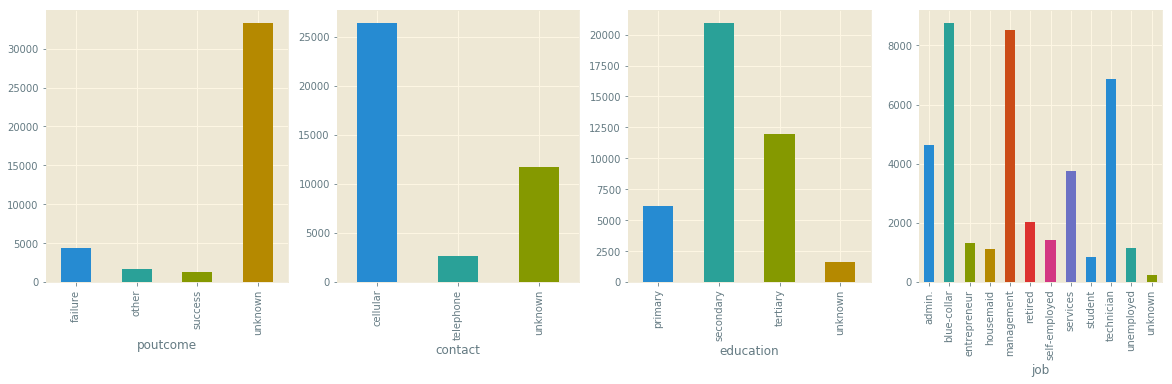

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=4)

for i, col in enumerate(["poutcome", "contact", "education", "job"]):
    X_train.groupby(col).count().previous.plot('bar', figsize=(20, 5), ax=axes[i])

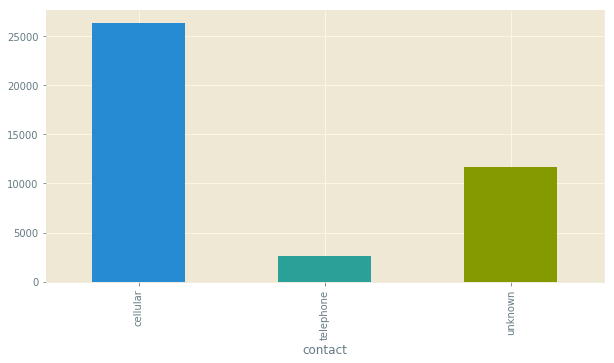

In [9]:
X_train.groupby("contact").count().previous.plot('bar', figsize=(10, 5))

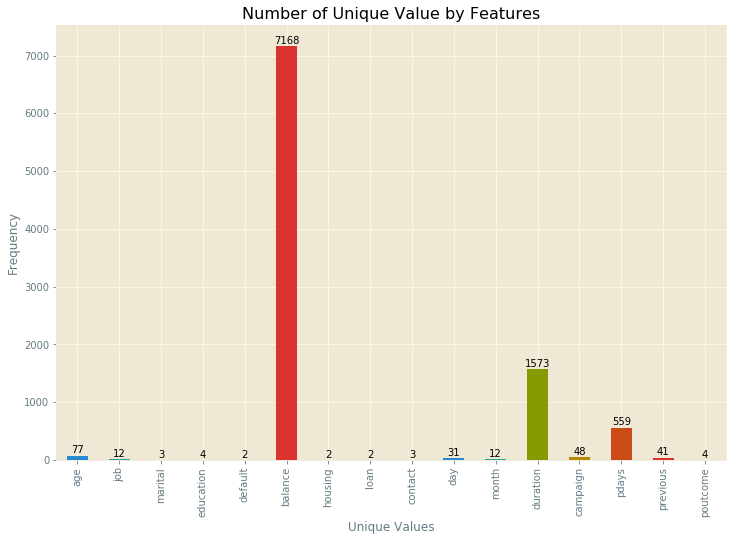

In [10]:
features = X_train.columns
unique_vals = [len(df.loc[:, col].unique()) for col in features]
freq_series = pd.Series(unique_vals)

# Plot the figure.
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_title('Number of Unique Value by Features')
ax.set_xlabel('Unique Values')
ax.set_ylabel('Frequency')
ax.set_xticklabels(features)

# Add value labels for each bar
rects = ax.patches

for rect, label in zip(rects, unique_vals):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

In [11]:
X_train.month.unique()

array(['jul', 'aug', 'may', 'nov', 'jun', 'apr', 'jan', 'feb', 'oct',
       'mar', 'sep', 'dec'], dtype=object)

In [12]:
X_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
14565,29,housemaid,married,primary,no,0,yes,no,cellular,15,jul,317,3,-1,0,unknown
20546,57,management,divorced,secondary,no,396,no,no,cellular,12,aug,108,2,-1,0,unknown
34495,54,blue-collar,married,primary,no,714,no,no,cellular,5,may,225,1,-1,0,unknown
13814,52,services,married,secondary,no,2072,no,no,cellular,10,jul,224,1,-1,0,unknown
42153,34,management,married,tertiary,no,1778,no,no,cellular,4,nov,358,1,162,2,failure


In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

corr_df = X_train.copy()

months = {"jan": 1, "feb": 2, "mar": 3, "apr": 4, "may": 5, "jun": 6, 
          "jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12}
corr_df.month = corr_df.month.apply(lambda x: months[x])

edu = {"unknown": 0, "primary": 1, "secondary": 2, "tertiary": 3}
corr_df.education = corr_df.education.apply(lambda x: edu[x])

bin_map = {"yes": 1, "no": 0}
bin_cols = corr_df.loc[:, ["default", "housing", "loan"]].apply(
    lambda x: x.map(bin_map))
corr_df.loc[:, ["default", "housing", "loan"]] = bin_cols

corr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40689 entries, 14565 to 15795
Data columns (total 16 columns):
age          40689 non-null int64
job          40689 non-null object
marital      40689 non-null object
education    40689 non-null int64
default      40689 non-null int64
balance      40689 non-null int64
housing      40689 non-null int64
loan         40689 non-null int64
contact      40689 non-null object
day          40689 non-null int64
month        40689 non-null int64
duration     40689 non-null int64
campaign     40689 non-null int64
pdays        40689 non-null int64
previous     40689 non-null int64
poutcome     40689 non-null object
dtypes: int64(12), object(4)
memory usage: 5.3+ MB


[]

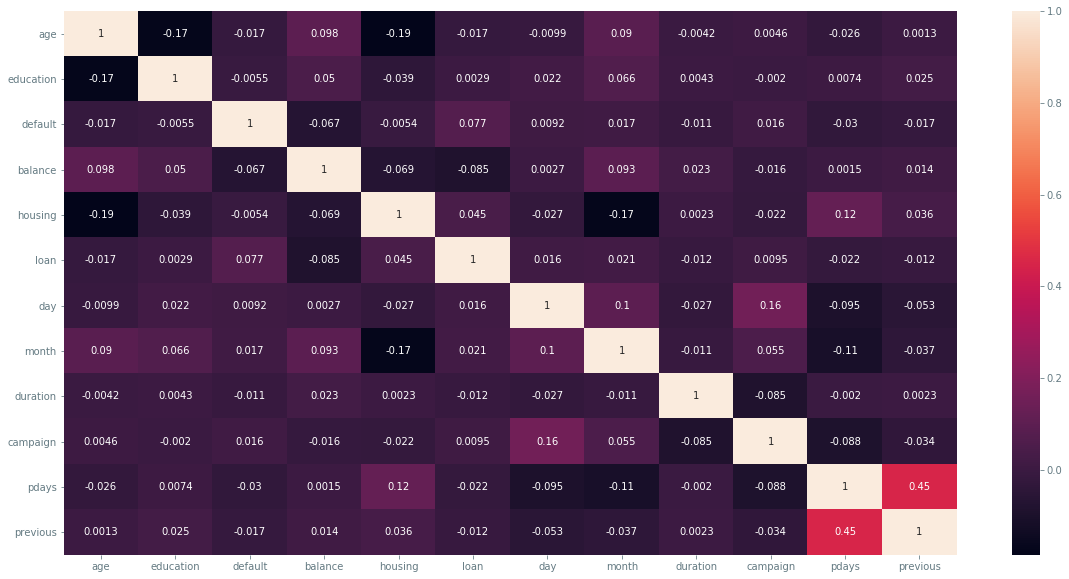

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
sns.heatmap(corr_df.corr(), annot=True, ax=ax)
plt.plot()

In [15]:
from scipy import stats
from collections import Counter

z_threshold = 3
print(corr_df.select_dtypes("int"))
z = np.abs(stats.zscore(corr_df.select_dtypes("int")))
print(z)
z_outliers = np.where(z > z_threshold)
print(z_outliers[0])
print(corr_df.iloc[z_outliers[0]].index)

if len(z_outliers[0]) < len(corr_df) * 0.05:
    corr_df.drop(corr_df.iloc[z_outliers[0]].index, inplace=True)
    
corr_df.head(10)

       age  education  default  balance  housing  loan  day  month  duration  \
14565   29          1        0        0        1     0   15      7       317   
20546   57          2        0      396        0     0   12      8       108   
34495   54          1        0      714        0     0    5      5       225   
13814   52          2        0     2072        0     0   10      7       224   
42153   34          3        0     1778        0     0    4     11       358   
19443   50          2        0      706        1     0    6      8      1250   
14942   40          2        0      641        0     0   16      7       156   
3277    43          1        0      960        1     1   15      5       241   
15158   59          3        0     6108        1     0   17      7       796   
27468   53          2        0     2693        0     0   21     11       140   
17155   35          3        0      670        1     0   28      7       177   
16379   49          2        1     2405 

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
14565,29,housemaid,married,1,0,0,1,0,cellular,15,7,317,3,-1,0,unknown
20546,57,management,divorced,2,0,396,0,0,cellular,12,8,108,2,-1,0,unknown
34495,54,blue-collar,married,1,0,714,0,0,cellular,5,5,225,1,-1,0,unknown
13814,52,services,married,2,0,2072,0,0,cellular,10,7,224,1,-1,0,unknown
42153,34,management,married,3,0,1778,0,0,cellular,4,11,358,1,162,2,failure
19443,50,admin.,married,2,0,706,1,0,cellular,6,8,1250,4,-1,0,unknown
14942,40,technician,single,2,0,641,0,0,cellular,16,7,156,6,-1,0,unknown
3277,43,unemployed,married,1,0,960,1,1,unknown,15,5,241,2,-1,0,unknown
15158,59,retired,married,3,0,6108,1,0,cellular,17,7,796,2,-1,0,unknown
27468,53,management,married,2,0,2693,0,0,cellular,21,11,140,1,-1,0,unknown


In [16]:
# unique_vals = [len(df.loc[:, col].unique()) for col in features]

# to_categorical = (freq_series == 2)
# print(X_train_tmp.values[:, 4])
# ct = ColumnTransformer(
#     [("ord_enc", OrdinalEncoder(), [4, 6, 7])],
#     remainder='passthrough'
# )
# print(X_train_tmp.values)
# xx = ct.fit_transform(X_train_tmp.values)
# corr_df = pd.DataFrame(xx, columns=features)

# corr_df

In [17]:
categorical_threshold = 100
categorical_features = freq_series < categorical_threshold
categorical_features

0      True
1      True
2      True
3      True
4      True
5     False
6      True
7      True
8      True
9      True
10     True
11    False
12     True
13    False
14     True
15     True
dtype: bool

In [18]:
expected_features = sum([x if x < 100 else 1 for x in freq_series])
f"#features expected after one-hot encoding: {expected_features}"

'#features expected after one-hot encoding: 244'

In [19]:
categorical_features

0      True
1      True
2      True
3      True
4      True
5     False
6      True
7      True
8      True
9      True
10     True
11    False
12     True
13    False
14     True
15     True
dtype: bool

In [20]:
from sklearn.preprocessing import OneHotEncoder

ct = ColumnTransformer(
    [('oh_enc', OneHotEncoder(sparse=False), categorical_features)],
    remainder='passthrough'
)

X_train_fit = ct.fit_transform(X_train.values)
X_train_fit_shape = X_train_fit.shape
print(X_train_fit_shape)
print(X_train_fit)

(40689, 243)
[[0.0 0.0 0.0 ... 0 317 -1]
 [0.0 0.0 0.0 ... 396 108 -1]
 [0.0 0.0 0.0 ... 714 225 -1]
 ...
 [0.0 0.0 0.0 ... 1317 239 -1]
 [0.0 0.0 0.0 ... 165 111 -1]
 [0.0 0.0 0.0 ... -41 68 -1]]


In [21]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import LabelEncoder
from collections import OrderedDict


class DataframeFeatureDrop(BaseEstimator, TransformerMixin):
    def __init__(self, drop_attrs):
        self.drop_attrs = drop_attrs
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(self.drop_attrs, axis=1)
    
    
class DataframeRowDrop(BaseEstimator, TransformerMixin): 
    def __init__(self, row_index):
        self.row_index = row_index 
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(X.iloc[self.row_index].index)
    
    
class DataframeFeatureMapping(BaseEstimator, TransformerMixin):
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        # print(kwargs)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        tmp = X.copy()
        for col, mapping in self.kwargs.items():
            tmp.loc[:, col] = tmp.loc[:, col].apply(lambda x: mapping[x])
        return tmp
    
    
def generate_categorical_encoder(df, features_to_encode):
    encoders = OrderedDict()
    all_features = list(df.columns)
    
    for col in features_to_encode:
        if col in all_features and df.loc[:, col].dtype == object:
            col_index = all_features.index(col)
            encoders[col_index] = OrdinalEncoder()
                
    return encoders
    
    
class DataframeCategoricalEncoding(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_encode):
        self.features_to_encode = features_to_encode

    def fit(self, X, y=None):
        self.__categorical_encs = generate_categorical_encoder(
            X, self.features_to_encode)
        
        for col, enc in self.__categorical_encs.items():
            enc.fit(X.values[:, col].reshape(-1, 1))
        
        return self
    
    def transform(self, X):
        encoder_attr = "_DataframeCategoricalEncoding__categorical_encs"

        if hasattr(self, encoder_attr):
            X_tmp = X.copy()
            for col, enc in self.__categorical_encs.items():
                enc_col = enc.transform(X_tmp.values[:, col].reshape(-1, 1))
                X_tmp.iloc[:, col] = enc_col.reshape(-1, 1)
            res = X_tmp
        else:
            res = self.fit_transform(X)

        return res
    
X_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
14565,29,housemaid,married,primary,no,0,yes,no,cellular,15,jul,317,3,-1,0,unknown
20546,57,management,divorced,secondary,no,396,no,no,cellular,12,aug,108,2,-1,0,unknown
34495,54,blue-collar,married,primary,no,714,no,no,cellular,5,may,225,1,-1,0,unknown
13814,52,services,married,secondary,no,2072,no,no,cellular,10,jul,224,1,-1,0,unknown
42153,34,management,married,tertiary,no,1778,no,no,cellular,4,nov,358,1,162,2,failure


In [22]:
df_enc = DataframeCategoricalEncoding(["job", "marital", "contact"])
xx = df_enc.fit_transform(X_train)
xx.head(20)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
14565,29,3.0,1.0,primary,no,0,yes,no,0.0,15,jul,317,3,-1,0,unknown
20546,57,4.0,0.0,secondary,no,396,no,no,0.0,12,aug,108,2,-1,0,unknown
34495,54,1.0,1.0,primary,no,714,no,no,0.0,5,may,225,1,-1,0,unknown
13814,52,7.0,1.0,secondary,no,2072,no,no,0.0,10,jul,224,1,-1,0,unknown
42153,34,4.0,1.0,tertiary,no,1778,no,no,0.0,4,nov,358,1,162,2,failure
19443,50,0.0,1.0,secondary,no,706,yes,no,0.0,6,aug,1250,4,-1,0,unknown
14942,40,9.0,2.0,secondary,no,641,no,no,0.0,16,jul,156,6,-1,0,unknown
3277,43,10.0,1.0,primary,no,960,yes,yes,2.0,15,may,241,2,-1,0,unknown
15158,59,5.0,1.0,tertiary,no,6108,yes,no,0.0,17,jul,796,2,-1,0,unknown
27468,53,4.0,1.0,secondary,no,2693,no,no,0.0,21,nov,140,1,-1,0,unknown


In [23]:
categorical_enc = ColumnTransformer(
    [("categorical_enc1", OrdinalEncoder(), [1])],
    remainder='passthrough')

categorical_enc2 = ColumnTransformer(
    [("categorical_enc1", OrdinalEncoder(), [2])],
    remainder='passthrough')

categorical_enc2.fit_transform(categorical_enc.fit_transform(X_train.values))

array([[1.0, 3.0, 29, ..., -1, 0, 'unknown'],
       [0.0, 4.0, 57, ..., -1, 0, 'unknown'],
       [1.0, 1.0, 54, ..., -1, 0, 'unknown'],
       ...,
       [0.0, 9.0, 34, ..., -1, 0, 'unknown'],
       [1.0, 5.0, 33, ..., -1, 0, 'unknown'],
       [1.0, 1.0, 38, ..., -1, 0, 'unknown']], dtype=object)

In [24]:
X_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
14565,29,housemaid,married,primary,no,0,yes,no,cellular,15,jul,317,3,-1,0,unknown
20546,57,management,divorced,secondary,no,396,no,no,cellular,12,aug,108,2,-1,0,unknown
34495,54,blue-collar,married,primary,no,714,no,no,cellular,5,may,225,1,-1,0,unknown
13814,52,services,married,secondary,no,2072,no,no,cellular,10,jul,224,1,-1,0,unknown
42153,34,management,married,tertiary,no,1778,no,no,cellular,4,nov,358,1,162,2,failure


In [25]:
from sklearn.pipeline import Pipeline

months = {"jan": 1, "feb": 2, "mar": 3, "apr": 4, "may": 5, "jun": 6, 
          "jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12}
edu = {"unknown": 0, "primary": 1, "secondary": 2, "tertiary": 3}
bin_map = {"yes": 1, "no": 0}

maps = {"month": months, "education": edu, "default": bin_map, 
        "housing": bin_map, "loan": bin_map}

# ct = ColumnTransformer(
#     [('oh_enc', OneHotEncoder(sparse=False), categorical_features)],
#     remainder='passthrough'
# )    

# DataframeRowDrop(z_outliers[0])

trn_pipe = Pipeline([
    ("feature_drop", DataframeFeatureDrop(["poutcome"])),
    # ("row_drop", DataframeRowDrop(z_outliers[0])),
    ("feature_map", DataframeFeatureMapping(**maps)),
    ("categorical_enc", DataframeCategoricalEncoding(["job", "marital", "contact"]))
])

X_train_pipe = trn_pipe.fit_transform(X_train)
X_train_pipe.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous
14565,29,3.0,1.0,1,0,0,1,0,0.0,15,7,317,3,-1,0
20546,57,4.0,0.0,2,0,396,0,0,0.0,12,8,108,2,-1,0
34495,54,1.0,1.0,1,0,714,0,0,0.0,5,5,225,1,-1,0
13814,52,7.0,1.0,2,0,2072,0,0,0.0,10,7,224,1,-1,0
42153,34,4.0,1.0,3,0,1778,0,0,0.0,4,11,358,1,162,2


In [26]:
def remove_outliers(X_train, y_train):
    X_tmp = X_train.copy()
    y_tmp = y_train.copy()
    
    z_threshold = 4
    z = np.abs(stats.zscore(X_train))
    z_outliers = np.where(z > z_threshold)
        
    if len(z_outliers[0]) < len(X_train) * 0.1:
        mask = np.ones(len(X_tmp), dtype=bool)
        mask[z_outliers[0]] = False
        X_tmp = X_tmp[mask, :]
        y_tmp = y_tmp[mask, :]
    else:
        pass # use imputation
    
    return X_tmp, y_tmp

x_t, y_t = remove_outliers(X_train_pipe.values, y_train)

## Models

In [27]:
from sklearn.metrics import accuracy_score, classification_report

Preprocessing:
- create drop column class for pipeline - drop poutcome
- remove outlier rows based on z-score for continuous features - features which come at int64
- imputation for categorical features - initially contact, education, job (see if this works well and then if not use imputation)
- create encoding class for pipeline to take dictionary and column name OR just use OrdinalEncoder OR go straight to one-hot encoding of models


- run some baseline models without one-hot encoding to determine feature-importance and try the tests for feature importance from the old kaggle notebooks
- from this maybe drop some features if completely irrelevant


- PCA of features for one hot encoding
- try more complex models, use paper as a reference point
- remember to scale features for certain features
- build a number of weak learners, use them to build a stacked generalisation
- compare the stacked generalisation with Out of the box model


- For the final model, do a final grid search + a bayesian search coded up manually 


- Write the solution into a formal class file with hardcoded hyperparams. 

### Baseline Models

#### SVC with scaling

In [341]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler

trn_pipe = Pipeline([
    ("feature_drop", DataframeFeatureDrop(["poutcome"])),
    ("feature_map", DataframeFeatureMapping(**maps)),
    ("categorical_enc", DataframeCategoricalEncoding(["job", "marital", "contact"]))
])

X_train2 = trn_pipe.fit_transform(X_train)

X_train_clean, y_train_clean = remove_outliers(X_train2.values, y_train)

svc_pipeline = Pipeline([
    # ("scaler", StandardScaler()),
    ("svc", LinearSVC(random_state=41, loss="hinge"))
])

svc_pipeline.fit(X_train_clean, y_train_clean)
y_pred = svc.predict(X_train_clean)
relative_acc = accuracy_score(y_pred, y_train_clean)
print(relative_acc)

0.8914607035438734


In [342]:
X_test2 = trn_pipe.transform(X_test)
y_test_pred = svc_pipeline.predict(X_test2)
relative_acc = accuracy_score(y_test_pred, y_test)
print(relative_acc)

0.8794781070322866


In [226]:
print(classification_report(y_test.reshape(1, -1)[0], 
                            y_test_pred, target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93      3968
           1       0.00      0.00      0.00       554

   micro avg       0.88      0.88      0.88      4522
   macro avg       0.44      0.50      0.47      4522
weighted avg       0.77      0.88      0.82      4522



#### SVC with weighted class initialisation

In [227]:
from sklearn.svm import LinearSVC

trn_pipe = Pipeline([
    ("feature_drop", DataframeFeatureDrop(["poutcome"])),
    ("feature_map", DataframeFeatureMapping(**maps)),
    ("categorical_enc", DataframeCategoricalEncoding(["job", "marital", "contact"]))
])

X_train2 = trn_pipe.fit_transform(X_train)

X_train_clean, y_train_clean = remove_outliers(X_train2.values, y_train)

svc = LinearSVC(random_state=41, class_weight="balanced", loss="hinge")
svc.fit(X_train_clean, y_train_clean)

y_pred = svc.predict(X_train_clean)
relative_acc = accuracy_score(y_pred, y_train_clean)
print(relative_acc)

0.8914607035438734


In [228]:
X_test2 = trn_pipe.transform(X_test)
y_test_pred = svc.predict(X_test2)
relative_acc = accuracy_score(y_test_pred, y_test)
print(relative_acc)

0.8794781070322866


In [229]:
print(classification_report(y_test.reshape(1, -1)[0], 
                            y_test_pred, target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       0.89      0.99      0.93      3968
           1       0.54      0.11      0.18       554

   micro avg       0.88      0.88      0.88      4522
   macro avg       0.71      0.55      0.56      4522
weighted avg       0.85      0.88      0.84      4522



#### ENN with SVC

In [230]:
import sys
!{sys.executable} -m pip install imblearn

In [231]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

trn_pipe = Pipeline([
    ("feature_drop", DataframeFeatureDrop(["poutcome"])),
    ("feature_map", DataframeFeatureMapping(**maps)),
    ("categorical_enc", DataframeCategoricalEncoding(["job", "marital", "contact"]))
])

X_train2 = trn_pipe.fit_transform(X_train)

X_train_clean, y_train_clean = remove_outliers(X_train2.values, y_train)

enn = EditedNearestNeighbours(n_neighbors=6)
X, y = enn.fit_sample(X_train_clean, y_train_clean)

smote_pipe = LinearSVC(random_state=41, class_weight="balanced", loss="hinge")
smote_pipe.fit(X, y)

y_pred = smote_pipe.predict(X_train_clean)
relative_acc = accuracy_score(y_pred, y_train_clean)
print(relative_acc)

0.8932914868575912


In [232]:
X_test2 = trn_pipe.transform(X_test)

y_test_pred = smote_pipe.predict(X_test2)
relative_acc = accuracy_score(y_test_pred, y_test)
print(relative_acc)

0.8794781070322866


In [233]:
print(classification_report(y_test.reshape(1, -1)[0], 
                            y_test_pred, target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      3968
           1       0.53      0.15      0.23       554

   micro avg       0.88      0.88      0.88      4522
   macro avg       0.71      0.56      0.58      4522
weighted avg       0.85      0.88      0.85      4522



#### Random Forest Not Removing Outliers

In [308]:
from sklearn.ensemble import RandomForestClassifier

trn_pipe = Pipeline([
    ("feature_drop", DataframeFeatureDrop(["poutcome"])),
    ("feature_map", DataframeFeatureMapping(**maps)),
    ("categorical_enc", DataframeCategoricalEncoding(["job", "marital", "contact"]))
])

X_train2 = trn_pipe.fit_transform(X_train)

rdm_forest = RandomForestClassifier(max_depth=50, n_estimators=50, random_state=42,
                                    n_jobs=-1, max_features="sqrt")
rdm_forest.fit(X_train2, y_train)

y_pred = rdm_forest.predict(X_train2)
relative_acc = accuracy_score(y_pred, y_train)
print(relative_acc)

0.999827963331613


In [309]:
X_test2 = trn_pipe.transform(X_test)

y_test_pred = rdm_forest.predict(X_test2)
relative_acc = accuracy_score(y_test_pred, y_test)
print(relative_acc)

0.9000442282176029


In [310]:
print(classification_report(y_test.reshape(1, -1)[0], 
                            y_test_pred, target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      3968
           1       0.65      0.40      0.49       554

   micro avg       0.90      0.90      0.90      4522
   macro avg       0.79      0.68      0.72      4522
weighted avg       0.89      0.90      0.89      4522



#### Random Forest

In [311]:
from sklearn.ensemble import RandomForestClassifier

trn_pipe = Pipeline([
    ("feature_drop", DataframeFeatureDrop(["poutcome"])),
    ("feature_map", DataframeFeatureMapping(**maps)),
    ("categorical_enc", DataframeCategoricalEncoding(["job", "marital", "contact"]))
])

X_train2 = trn_pipe.fit_transform(X_train)

X_train_clean, y_train_clean = remove_outliers(X_train2.values, y_train)

rdm_forest = RandomForestClassifier(max_depth=50, n_estimators=50, random_state=42,
                                    n_jobs=-1, max_features="sqrt")
rdm_forest.fit(X_train_clean, y_train_clean)

y_pred = rdm_forest.predict(X_train_clean)
relative_acc = accuracy_score(y_pred, y_train_clean)
print(relative_acc)

0.9996861514319341


In [312]:
X_test2 = trn_pipe.transform(X_test)

y_test_pred = rdm_forest.predict(X_test2)
relative_acc = accuracy_score(y_test_pred, y_test)
print(relative_acc)

0.8971693940734189


In [313]:
print(classification_report(y_test.reshape(1, -1)[0], 
                            y_test_pred, target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      3968
           1       0.64      0.37      0.47       554

   micro avg       0.90      0.90      0.90      4522
   macro avg       0.78      0.67      0.71      4522
weighted avg       0.88      0.90      0.89      4522



#### ENN with Random Forest

In [324]:
from sklearn.ensemble import RandomForestClassifier

trn_pipe = Pipeline([
    ("feature_drop", DataframeFeatureDrop(["poutcome"])),
    ("feature_map", DataframeFeatureMapping(**maps)),
    ("categorical_enc", DataframeCategoricalEncoding(["job", "marital", "contact"]))
])

X_train2 = trn_pipe.fit_transform(X_train)

enn = EditedNearestNeighbours(n_neighbors=1)
X_train_clean, y_train_clean = enn.fit_sample(X_train2, y_train)

rdm_forest = RandomForestClassifier(max_depth=50, n_estimators=50, random_state=42,
                                    n_jobs=-1, max_features="sqrt")
rdm_forest.fit(X_train_clean, y_train_clean)

y_pred = rdm_forest.predict(X_train2)
relative_acc = accuracy_score(y_pred, y_train)
print(relative_acc)

0.9800437464671041


In [325]:
X_test2 = trn_pipe.transform(X_test)

y_test_pred = rdm_forest.predict(X_test2)
relative_acc = accuracy_score(y_test_pred, y_test)
print(relative_acc)

0.9029190623617869


In [326]:
print(classification_report(y_test.reshape(1, -1)[0], 
                            y_test_pred, target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      3968
           1       0.62      0.55      0.58       554

   micro avg       0.90      0.90      0.90      4522
   macro avg       0.78      0.75      0.76      4522
weighted avg       0.90      0.90      0.90      4522



#### Gradient Boosting Classifier

In [187]:
from sklearn.ensemble import GradientBoostingClassifier

trn_pipe = Pipeline([
    ("feature_drop", DataframeFeatureDrop(["poutcome"])),
    ("feature_map", DataframeFeatureMapping(**maps)),
    ("categorical_enc", DataframeCategoricalEncoding(["job", "marital", "contact"]))
])

X_train2 = trn_pipe.fit_transform(X_train)

X_train_clean, y_train_clean = remove_outliers(X_train2.values, y_train)

gbc_clf = GradientBoostingClassifier(n_estimators=9000, learning_rate=0.04, subsample=0.4,
                                     random_state=42, verbose=2, max_leaf_nodes=8, max_depth=3)
gbc_clf.fit(X_train_clean, y_train_clean)

y_pred = gbc_clf.predict(X_train_clean)
relative_acc = accuracy_score(y_pred, y_train_clean)
print(relative_acc)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.6761           0.0163            4.62m
         2           0.6798           0.0140            4.56m
         3           0.6567           0.0133            4.48m
         4           0.6290           0.0116            4.52m
         5           0.6364           0.0096            4.45m
         6           0.6196           0.0089            4.43m
         7           0.6069           0.0085            4.43m
         8           0.6039           0.0074            4.55m
         9           0.5903           0.0064            4.49m
        10           0.5897           0.0070            4.46m
        11           0.5809           0.0057            4.45m
        12           0.5899           0.0056            4.44m
        13           0.5786           0.0050            4.43m
        14           0.5773           0.0050            4.41m
        15           0.5767           0.0047            4.43m
       

       137           0.4350           0.0002            4.43m
       138           0.4332           0.0000            4.43m
       139           0.4398           0.0001            4.43m
       140           0.4265           0.0003            4.43m
       141           0.4224          -0.0000            4.42m
       142           0.4346          -0.0000            4.42m
       143           0.4350           0.0006            4.42m
       144           0.4269           0.0002            4.41m
       145           0.4312           0.0002            4.41m
       146           0.4362          -0.0000            4.41m
       147           0.4347           0.0006            4.42m
       148           0.4354           0.0001            4.41m
       149           0.4180           0.0003            4.41m
       150           0.4307           0.0001            4.41m
       151           0.4163           0.0004            4.40m
       152           0.4241           0.0001            4.40m
       1

       276           0.4020          -0.0000            4.26m
       277           0.4063          -0.0000            4.26m
       278           0.3994          -0.0000            4.26m
       279           0.4052           0.0002            4.26m
       280           0.3914          -0.0000            4.25m
       281           0.4048          -0.0001            4.25m
       282           0.4032          -0.0000            4.25m
       283           0.4006          -0.0000            4.25m
       284           0.3976          -0.0000            4.25m
       285           0.3983           0.0000            4.25m
       286           0.4039          -0.0000            4.24m
       287           0.4078          -0.0000            4.24m
       288           0.4098          -0.0000            4.24m
       289           0.3985          -0.0001            4.24m
       290           0.4057           0.0000            4.24m
       291           0.4029          -0.0000            4.24m
       2

       409           0.3881          -0.0001            4.10m
       410           0.3831          -0.0000            4.10m
       411           0.3907          -0.0000            4.10m
       412           0.3907           0.0001            4.10m
       413           0.3907          -0.0000            4.10m
       414           0.3830          -0.0000            4.10m
       415           0.3767          -0.0000            4.10m
       416           0.3955           0.0001            4.10m
       417           0.3871          -0.0000            4.10m
       418           0.3792           0.0000            4.10m
       419           0.3931          -0.0000            4.09m
       420           0.3809           0.0001            4.09m
       421           0.3904           0.0000            4.09m
       422           0.3855          -0.0000            4.08m
       423           0.3836          -0.0000            4.08m
       424           0.3833          -0.0000            4.08m
       4

       544           0.3736          -0.0000            3.98m
       545           0.3772          -0.0001            3.98m
       546           0.3755          -0.0001            3.98m
       547           0.3673          -0.0000            3.98m
       548           0.3858           0.0001            3.98m
       549           0.3713          -0.0000            3.98m
       550           0.3800          -0.0000            3.97m
       551           0.3842          -0.0000            3.97m
       552           0.3737          -0.0000            3.97m
       553           0.3754          -0.0000            3.97m
       554           0.3865          -0.0001            3.97m
       555           0.3683          -0.0000            3.97m
       556           0.3593          -0.0000            3.97m
       557           0.3812          -0.0000            3.97m
       558           0.3757           0.0000            3.97m
       559           0.3822           0.0000            3.96m
       5

       681           0.3663          -0.0000            3.88m
       682           0.3667           0.0000            3.88m
       683           0.3706          -0.0000            3.88m
       684           0.3663          -0.0001            3.88m
       685           0.3664          -0.0000            3.88m
       686           0.3677          -0.0000            3.88m
       687           0.3698          -0.0000            3.88m
       688           0.3607          -0.0000            3.88m
       689           0.3731           0.0001            3.88m
       690           0.3682          -0.0000            3.88m
       691           0.3676          -0.0000            3.88m
       692           0.3708          -0.0000            3.88m
       693           0.3756          -0.0000            3.88m
       694           0.3683          -0.0000            3.88m
       695           0.3574          -0.0000            3.88m
       696           0.3642          -0.0000            3.87m
       6

       815           0.3606          -0.0000            3.80m
       816           0.3673          -0.0000            3.80m
       817           0.3726          -0.0001            3.80m
       818           0.3658          -0.0000            3.80m
       819           0.3584          -0.0000            3.80m
       820           0.3628          -0.0000            3.80m
       821           0.3560           0.0000            3.80m
       822           0.3573          -0.0000            3.80m
       823           0.3666          -0.0001            3.80m
       824           0.3567          -0.0000            3.80m
       825           0.3641          -0.0000            3.80m
       826           0.3612          -0.0001            3.80m
       827           0.3597          -0.0000            3.80m
       828           0.3556          -0.0000            3.80m
       829           0.3655          -0.0000            3.80m
       830           0.3530          -0.0000            3.79m
       8

       955           0.3576          -0.0001            3.70m
       956           0.3641          -0.0000            3.70m
       957           0.3543           0.0000            3.70m
       958           0.3455          -0.0000            3.70m
       959           0.3631          -0.0000            3.70m
       960           0.3520          -0.0001            3.70m
       961           0.3573          -0.0000            3.70m
       962           0.3511          -0.0000            3.70m
       963           0.3495          -0.0000            3.70m
       964           0.3567          -0.0000            3.70m
       965           0.3526          -0.0000            3.70m
       966           0.3494          -0.0001            3.70m
       967           0.3590          -0.0000            3.70m
       968           0.3477          -0.0000            3.70m
       969           0.3533          -0.0000            3.69m
       970           0.3595          -0.0000            3.69m
       9

      1093           0.3344          -0.0001            3.63m
      1094           0.3402          -0.0000            3.63m
      1095           0.3546           0.0000            3.63m
      1096           0.3472          -0.0000            3.63m
      1097           0.3523          -0.0001            3.63m
      1098           0.3481           0.0000            3.63m
      1099           0.3483          -0.0001            3.62m
      1100           0.3552          -0.0001            3.62m
      1101           0.3519          -0.0001            3.62m
      1102           0.3464          -0.0000            3.62m
      1103           0.3477          -0.0000            3.62m
      1104           0.3536          -0.0001            3.62m
      1105           0.3413          -0.0001            3.62m
      1106           0.3467          -0.0000            3.62m
      1107           0.3490          -0.0000            3.62m
      1108           0.3423          -0.0001            3.62m
      11

      1232           0.3466          -0.0000            3.56m
      1233           0.3395          -0.0001            3.56m
      1234           0.3371          -0.0001            3.56m
      1235           0.3320          -0.0001            3.56m
      1236           0.3458          -0.0000            3.56m
      1237           0.3515          -0.0000            3.56m
      1238           0.3388          -0.0001            3.56m
      1239           0.3499          -0.0001            3.56m
      1240           0.3398          -0.0000            3.56m
      1241           0.3431          -0.0000            3.56m
      1242           0.3442          -0.0000            3.56m
      1243           0.3491          -0.0000            3.56m
      1244           0.3383          -0.0000            3.56m
      1245           0.3430          -0.0000            3.56m
      1246           0.3483          -0.0000            3.56m
      1247           0.3349          -0.0001            3.56m
      12

      1370           0.3319          -0.0001            3.51m
      1371           0.3413           0.0000            3.51m
      1372           0.3405          -0.0000            3.51m
      1373           0.3298          -0.0000            3.51m
      1374           0.3404          -0.0001            3.51m
      1375           0.3266          -0.0001            3.51m
      1376           0.3399          -0.0000            3.51m
      1377           0.3470          -0.0000            3.51m
      1378           0.3409          -0.0000            3.51m
      1379           0.3340          -0.0000            3.51m
      1380           0.3302          -0.0000            3.51m
      1381           0.3405          -0.0000            3.51m
      1382           0.3433           0.0000            3.51m
      1383           0.3371          -0.0000            3.50m
      1384           0.3486          -0.0000            3.50m
      1385           0.3356          -0.0001            3.50m
      13

      1505           0.3318          -0.0000            3.47m
      1506           0.3273          -0.0000            3.47m
      1507           0.3301          -0.0000            3.47m
      1508           0.3411          -0.0000            3.47m
      1509           0.3334          -0.0000            3.46m
      1510           0.3243          -0.0000            3.46m
      1511           0.3368          -0.0000            3.46m
      1512           0.3217          -0.0000            3.46m
      1513           0.3365          -0.0000            3.46m
      1514           0.3292          -0.0001            3.46m
      1515           0.3337          -0.0000            3.46m
      1516           0.3283          -0.0000            3.46m
      1517           0.3346          -0.0000            3.46m
      1518           0.3382          -0.0001            3.46m
      1519           0.3403          -0.0000            3.46m
      1520           0.3217          -0.0001            3.46m
      15

      1638           0.3202          -0.0001            3.42m
      1639           0.3194          -0.0000            3.42m
      1640           0.3308          -0.0000            3.42m
      1641           0.3291          -0.0000            3.42m
      1642           0.3302          -0.0000            3.42m
      1643           0.3242          -0.0000            3.42m
      1644           0.3276          -0.0000            3.42m
      1645           0.3284          -0.0000            3.42m
      1646           0.3289          -0.0000            3.42m
      1647           0.3240          -0.0000            3.42m
      1648           0.3293          -0.0000            3.42m
      1649           0.3251          -0.0000            3.42m
      1650           0.3288          -0.0000            3.42m
      1651           0.3315          -0.0000            3.42m
      1652           0.3283          -0.0000            3.42m
      1653           0.3260          -0.0000            3.42m
      16

      1771           0.3190          -0.0000            3.38m
      1772           0.3277          -0.0000            3.38m
      1773           0.3267          -0.0000            3.38m
      1774           0.3220          -0.0000            3.38m
      1775           0.3273          -0.0000            3.38m
      1776           0.3260          -0.0000            3.38m
      1777           0.3187          -0.0001            3.38m
      1778           0.3226          -0.0000            3.38m
      1779           0.3244           0.0001            3.37m
      1780           0.3166          -0.0000            3.37m
      1781           0.3211          -0.0000            3.37m
      1782           0.3191          -0.0000            3.37m
      1783           0.3204          -0.0000            3.37m
      1784           0.3256          -0.0000            3.37m
      1785           0.3274          -0.0001            3.37m
      1786           0.3227          -0.0000            3.37m
      17

      1911           0.3167          -0.0000            3.31m
      1912           0.3318          -0.0001            3.31m
      1913           0.3194          -0.0001            3.31m
      1914           0.3204          -0.0000            3.31m
      1915           0.3167          -0.0001            3.31m
      1916           0.3227          -0.0000            3.31m
      1917           0.3057          -0.0000            3.31m
      1918           0.3126          -0.0001            3.31m
      1919           0.3196          -0.0001            3.31m
      1920           0.3083          -0.0001            3.31m
      1921           0.3285          -0.0000            3.31m
      1922           0.3201          -0.0000            3.31m
      1923           0.3258          -0.0000            3.31m
      1924           0.3144          -0.0000            3.31m
      1925           0.3104          -0.0000            3.31m
      1926           0.3216          -0.0001            3.31m
      19

      2046           0.3101          -0.0000            3.25m
      2047           0.3205           0.0000            3.25m
      2048           0.3107          -0.0000            3.25m
      2049           0.3065          -0.0000            3.25m
      2050           0.3122           0.0000            3.25m
      2051           0.3115          -0.0000            3.25m
      2052           0.3033          -0.0000            3.24m
      2053           0.3129          -0.0000            3.24m
      2054           0.3075          -0.0001            3.24m
      2055           0.3092          -0.0001            3.24m
      2056           0.3112          -0.0000            3.24m
      2057           0.3212          -0.0000            3.24m
      2058           0.3070          -0.0000            3.24m
      2059           0.3139          -0.0000            3.24m
      2060           0.3181          -0.0001            3.24m
      2061           0.3217           0.0001            3.24m
      20

      2186           0.3024          -0.0000            3.18m
      2187           0.3023          -0.0000            3.18m
      2188           0.3059          -0.0000            3.18m
      2189           0.3073          -0.0001            3.18m
      2190           0.2970          -0.0001            3.18m
      2191           0.3052          -0.0000            3.18m
      2192           0.3018          -0.0000            3.18m
      2193           0.3018          -0.0001            3.18m
      2194           0.3000          -0.0000            3.18m
      2195           0.3024          -0.0000            3.18m
      2196           0.3146          -0.0000            3.18m
      2197           0.3055          -0.0001            3.18m
      2198           0.3076          -0.0001            3.18m
      2199           0.3088          -0.0000            3.18m
      2200           0.3042          -0.0000            3.18m
      2201           0.2965          -0.0000            3.18m
      22

      2320           0.3033          -0.0000            3.12m
      2321           0.3070          -0.0000            3.12m
      2322           0.3105          -0.0000            3.12m
      2323           0.3010          -0.0001            3.12m
      2324           0.3095          -0.0000            3.12m
      2325           0.3108          -0.0000            3.12m
      2326           0.3037          -0.0000            3.12m
      2327           0.3049          -0.0000            3.12m
      2328           0.3040          -0.0001            3.12m
      2329           0.2968          -0.0000            3.12m
      2330           0.3059          -0.0001            3.12m
      2331           0.2961          -0.0000            3.12m
      2332           0.3082          -0.0001            3.12m
      2333           0.3011          -0.0000            3.11m
      2334           0.3082          -0.0001            3.11m
      2335           0.3102          -0.0000            3.11m
      23

      2458           0.2974          -0.0001            3.06m
      2459           0.2945          -0.0000            3.06m
      2460           0.3158          -0.0001            3.06m
      2461           0.2932          -0.0000            3.06m
      2462           0.3093          -0.0000            3.06m
      2463           0.3030          -0.0000            3.05m
      2464           0.2993          -0.0000            3.05m
      2465           0.3064          -0.0000            3.05m
      2466           0.2925          -0.0001            3.05m
      2467           0.2993          -0.0000            3.05m
      2468           0.2928          -0.0000            3.05m
      2469           0.3002          -0.0000            3.05m
      2470           0.3006          -0.0001            3.05m
      2471           0.2945          -0.0000            3.05m
      2472           0.3046          -0.0001            3.05m
      2473           0.3013          -0.0000            3.05m
      24

      2593           0.2923          -0.0000            3.00m
      2594           0.2988          -0.0000            3.00m
      2595           0.2958          -0.0000            3.00m
      2596           0.2988          -0.0000            3.00m
      2597           0.2952          -0.0000            3.00m
      2598           0.2934          -0.0000            3.00m
      2599           0.2980          -0.0000            3.00m
      2600           0.3041          -0.0000            3.00m
      2601           0.2967          -0.0000            3.00m
      2602           0.2972           0.0000            3.00m
      2603           0.3007          -0.0000            3.00m
      2604           0.2885          -0.0000            3.00m
      2605           0.2931          -0.0000            3.00m
      2606           0.2973          -0.0000            3.00m
      2607           0.2953          -0.0000            3.00m
      2608           0.2962          -0.0000            3.00m
      26

      2727           0.2941          -0.0000            2.95m
      2728           0.2877          -0.0000            2.95m
      2729           0.2956          -0.0000            2.95m
      2730           0.2998          -0.0000            2.95m
      2731           0.2923          -0.0000            2.95m
      2732           0.2947          -0.0001            2.95m
      2733           0.2909          -0.0000            2.94m
      2734           0.2887          -0.0000            2.94m
      2735           0.2970          -0.0000            2.94m
      2736           0.2858          -0.0000            2.94m
      2737           0.2830          -0.0000            2.94m
      2738           0.2827          -0.0000            2.94m
      2739           0.2849          -0.0000            2.94m
      2740           0.2939          -0.0000            2.94m
      2741           0.2829          -0.0000            2.94m
      2742           0.2850          -0.0000            2.94m
      27

      2861           0.2936          -0.0000            2.88m
      2862           0.2927          -0.0000            2.88m
      2863           0.2891          -0.0000            2.88m
      2864           0.2878          -0.0000            2.88m
      2865           0.2850          -0.0000            2.88m
      2866           0.2837          -0.0000            2.88m
      2867           0.2800          -0.0000            2.88m
      2868           0.2836          -0.0001            2.88m
      2869           0.2834          -0.0000            2.88m
      2870           0.2903          -0.0000            2.88m
      2871           0.2968          -0.0001            2.88m
      2872           0.2847          -0.0000            2.88m
      2873           0.2836          -0.0000            2.88m
      2874           0.2929          -0.0000            2.88m
      2875           0.2893          -0.0000            2.88m
      2876           0.2932          -0.0000            2.88m
      28

      2994           0.2857          -0.0000            2.82m
      2995           0.2778          -0.0000            2.82m
      2996           0.2818          -0.0000            2.82m
      2997           0.2860          -0.0000            2.82m
      2998           0.2689          -0.0000            2.82m
      2999           0.2860          -0.0001            2.81m
      3000           0.2888          -0.0001            2.81m
      3001           0.2851          -0.0000            2.81m
      3002           0.2856          -0.0000            2.81m
      3003           0.2835          -0.0000            2.81m
      3004           0.2882          -0.0000            2.81m
      3005           0.2818          -0.0000            2.81m
      3006           0.2861          -0.0000            2.81m
      3007           0.2866          -0.0000            2.81m
      3008           0.2805          -0.0001            2.81m
      3009           0.2897          -0.0000            2.81m
      30

      3129           0.2836          -0.0000            2.75m
      3130           0.2834          -0.0000            2.75m
      3131           0.2852          -0.0000            2.75m
      3132           0.2740          -0.0000            2.75m
      3133           0.2830          -0.0000            2.75m
      3134           0.2744          -0.0000            2.75m
      3135           0.2811          -0.0000            2.75m
      3136           0.2833          -0.0001            2.75m
      3137           0.2806          -0.0000            2.75m
      3138           0.2816          -0.0000            2.75m
      3139           0.2782          -0.0000            2.74m
      3140           0.2867          -0.0000            2.74m
      3141           0.2829          -0.0000            2.74m
      3142           0.2820          -0.0000            2.74m
      3143           0.2795          -0.0000            2.74m
      3144           0.2851          -0.0000            2.74m
      31

      3263           0.2806          -0.0000            2.68m
      3264           0.2871          -0.0000            2.68m
      3265           0.2754          -0.0000            2.68m
      3266           0.2819          -0.0000            2.68m
      3267           0.2793           0.0000            2.68m
      3268           0.2708          -0.0000            2.68m
      3269           0.2767          -0.0000            2.68m
      3270           0.2771          -0.0000            2.68m
      3271           0.2738          -0.0000            2.68m
      3272           0.2808          -0.0000            2.68m
      3273           0.2796          -0.0000            2.68m
      3274           0.2779          -0.0000            2.68m
      3275           0.2848          -0.0001            2.68m
      3276           0.2719          -0.0000            2.68m
      3277           0.2705          -0.0000            2.68m
      3278           0.2785          -0.0000            2.68m
      32

      3400           0.2750          -0.0001            2.62m
      3401           0.2753          -0.0001            2.62m
      3402           0.2741          -0.0000            2.62m
      3403           0.2725          -0.0000            2.62m
      3404           0.2786          -0.0001            2.62m
      3405           0.2744          -0.0000            2.62m
      3406           0.2752          -0.0000            2.61m
      3407           0.2784          -0.0000            2.61m
      3408           0.2714          -0.0000            2.61m
      3409           0.2808          -0.0000            2.61m
      3410           0.2719          -0.0001            2.61m
      3411           0.2770          -0.0001            2.61m
      3412           0.2775          -0.0001            2.61m
      3413           0.2780          -0.0000            2.61m
      3414           0.2708          -0.0000            2.61m
      3415           0.2758          -0.0000            2.61m
      34

      3537           0.2746          -0.0000            2.56m
      3538           0.2744          -0.0000            2.56m
      3539           0.2721          -0.0000            2.56m
      3540           0.2734          -0.0000            2.56m
      3541           0.2671          -0.0000            2.56m
      3542           0.2697          -0.0000            2.56m
      3543           0.2775          -0.0000            2.56m
      3544           0.2717          -0.0000            2.56m
      3545           0.2752          -0.0000            2.56m
      3546           0.2699          -0.0000            2.56m
      3547           0.2737          -0.0000            2.56m
      3548           0.2712          -0.0000            2.56m
      3549           0.2736          -0.0001            2.56m
      3550           0.2696          -0.0000            2.56m
      3551           0.2812          -0.0000            2.56m
      3552           0.2784          -0.0000            2.56m
      35

      3670           0.2639          -0.0000            2.50m
      3671           0.2719          -0.0000            2.50m
      3672           0.2697          -0.0000            2.50m
      3673           0.2622          -0.0000            2.50m
      3674           0.2679          -0.0000            2.50m
      3675           0.2621          -0.0000            2.50m
      3676           0.2700          -0.0000            2.50m
      3677           0.2702          -0.0000            2.50m
      3678           0.2785          -0.0000            2.50m
      3679           0.2704          -0.0000            2.50m
      3680           0.2594          -0.0000            2.50m
      3681           0.2748          -0.0001            2.50m
      3682           0.2668          -0.0001            2.50m
      3683           0.2735          -0.0000            2.50m
      3684           0.2642          -0.0000            2.50m
      3685           0.2669          -0.0000            2.50m
      36

      3809           0.2660          -0.0000            2.44m
      3810           0.2622          -0.0015            2.44m
      3811           0.2651          -0.0001            2.44m
      3812           0.2581          -0.0000            2.44m
      3813           0.2699          -0.0000            2.44m
      3814           0.2560          -0.0000            2.44m
      3815           0.2664          -0.0000            2.44m
      3816           0.2667          -0.0000            2.44m
      3817           0.2584          -0.0000            2.44m
      3818           0.2617          -0.0000            2.44m
      3819           0.2649          -0.0001            2.44m
      3820           0.2706          -0.0000            2.44m
      3821           0.2665          -0.0000            2.44m
      3822           0.2601          -0.0001            2.44m
      3823           0.2616          -0.0000            2.44m
      3824           0.2643          -0.0001            2.44m
      38

      3947           0.2673          -0.0000            2.38m
      3948           0.2619          -0.0001            2.38m
      3949           0.2601          -0.0000            2.38m
      3950           0.2551          -0.0000            2.38m
      3951           0.2642          -0.0000            2.38m
      3952           0.2569          -0.0000            2.38m
      3953           0.2700          -0.0001            2.37m
      3954           0.2675          -0.0001            2.37m
      3955           0.2588          -0.0001            2.37m
      3956           0.2588          -0.0000            2.37m
      3957           0.2566          -0.0001            2.37m
      3958           0.2659          -0.0000            2.37m
      3959           0.2578          -0.0000            2.37m
      3960           0.2608          -0.0000            2.37m
      3961           0.2650          -0.0000            2.37m
      3962           0.2556          -0.0001            2.37m
      39

      4081           0.2594          -0.0000            2.31m
      4082           0.2618          -0.0000            2.31m
      4083           0.2567          -0.0000            2.31m
      4084           0.2586          -0.0000            2.31m
      4085           0.2637          -0.0000            2.31m
      4086           0.2547          -0.0000            2.31m
      4087           0.2587          -0.0000            2.31m
      4088           0.2593          -0.0000            2.31m
      4089           0.2579          -0.0000            2.31m
      4090           0.2545          -0.0000            2.31m
      4091           0.2570          -0.0000            2.31m
      4092           0.2517          -0.0000            2.31m
      4093           0.2545          -0.0000            2.31m
      4094           0.2665          -0.0000            2.31m
      4095           0.2655          -0.0000            2.31m
      4096           0.2650          -0.0000            2.31m
      40

      4217           0.2490          -0.0000            2.25m
      4218           0.2643           0.0000            2.25m
      4219           0.2584          -0.0000            2.25m
      4220           0.2517          -0.0001            2.25m
      4221           0.2696          -0.0001            2.25m
      4222           0.2538          -0.0000            2.25m
      4223           0.2614          -0.0001            2.25m
      4224           0.2528          -0.0000            2.25m
      4225           0.2556          -0.0000            2.25m
      4226           0.2514          -0.0000            2.25m
      4227           0.2557          -0.0000            2.25m
      4228           0.2611          -0.0000            2.25m
      4229           0.2678          -0.0001            2.25m
      4230           0.2582          -0.0000            2.25m
      4231           0.2591          -0.0000            2.24m
      4232           0.2537          -0.0000            2.24m
      42

      4350           0.2505          -0.0000            2.19m
      4351           0.2533          -0.0000            2.19m
      4352           0.2518          -0.0000            2.19m
      4353           0.2546          -0.0000            2.19m
      4354           0.2493          -0.0000            2.19m
      4355           0.2489          -0.0000            2.19m
      4356           0.2516          -0.0000            2.19m
      4357           0.2514          -0.0000            2.19m
      4358           0.2483          -0.0000            2.19m
      4359           0.2560          -0.0000            2.19m
      4360           0.2589          -0.0000            2.19m
      4361           0.2531          -0.0000            2.19m
      4362           0.2492          -0.0000            2.19m
      4363           0.2421          -0.0000            2.19m
      4364           0.2591          -0.0000            2.19m
      4365           0.2534          -0.0000            2.18m
      43

      4487           0.2446          -0.0000            2.13m
      4488           0.2523          -0.0001            2.13m
      4489           0.2631          -0.0000            2.13m
      4490           0.2505          -0.0000            2.13m
      4491           0.2487          -0.0000            2.13m
      4492           0.2507          -0.0000            2.13m
      4493           0.2493          -0.0001            2.12m
      4494           0.2516          -0.0000            2.12m
      4495           0.2571          -0.0000            2.12m
      4496           0.2570          -0.0000            2.12m
      4497           0.2467          -0.0000            2.12m
      4498           0.2492          -0.0000            2.12m
      4499           0.2519          -0.0000            2.12m
      4500           0.2516          -0.0000            2.12m
      4501           0.2577          -0.0000            2.12m
      4502           0.2530          -0.0000            2.12m
      45

      4623           0.2526          -0.0000            2.06m
      4624           0.2534          -0.0000            2.06m
      4625           0.2492          -0.0000            2.06m
      4626           0.2503          -0.0000            2.06m
      4627           0.2469          -0.0000            2.06m
      4628           0.2590          -0.0000            2.06m
      4629           0.2517          -0.0000            2.06m
      4630           0.2456          -0.0000            2.06m
      4631           0.2514          -0.0000            2.06m
      4632           0.2511          -0.0000            2.06m
      4633           0.2543          -0.0001            2.06m
      4634           0.2475          -0.0000            2.06m
      4635           0.2458          -0.0000            2.06m
      4636           0.2466          -0.0000            2.05m
      4637           0.2443          -0.0000            2.05m
      4638           0.2449          -0.0000            2.05m
      46

      4756           0.2396          -0.0000            2.00m
      4757           0.2438          -0.0000            2.00m
      4758           0.2457          -0.0000            2.00m
      4759           0.2554          -0.0000            2.00m
      4760           0.2468          -0.0000            2.00m
      4761           0.2425          -0.0000            2.00m
      4762           0.2439          -0.0000            2.00m
      4763           0.2481          -0.0001            1.99m
      4764           0.2379          -0.0000            1.99m
      4765           0.2400          -0.0000            1.99m
      4766           0.2490          -0.0001            1.99m
      4767           0.2413          -0.0000            1.99m
      4768           0.2479          -0.0000            1.99m
      4769           0.2452          -0.0000            1.99m
      4770           0.2472          -0.0000            1.99m
      4771           0.2387          -0.0000            1.99m
      47

      4889           0.2422          -0.0000            1.93m
      4890           0.2372          -0.0000            1.93m
      4891           0.2361          -0.0000            1.93m
      4892           0.2397          -0.0000            1.93m
      4893           0.2405          -0.0000            1.93m
      4894           0.2442          -0.0001            1.93m
      4895           0.2445          -0.0000            1.93m
      4896           0.2445          -0.0000            1.93m
      4897           0.2438          -0.0000            1.93m
      4898           0.2429          -0.0000            1.93m
      4899           0.2425          -0.0000            1.93m
      4900           0.2392          -0.0000            1.93m
      4901           0.2410          -0.0000            1.93m
      4902           0.2347          -0.0000            1.93m
      4903           0.2432          -0.0000            1.93m
      4904           0.2404          -0.0000            1.93m
      49

      5025           0.2505           0.0000            1.87m
      5026           0.2348          -0.0001            1.87m
      5027           0.2369          -0.0000            1.87m
      5028           0.2357          -0.0000            1.87m
      5029           0.2389          -0.0000            1.87m
      5030           0.2412          -0.0000            1.87m
      5031           0.2371          -0.0001            1.87m
      5032           0.2488          -0.0000            1.87m
      5033           0.2347          -0.0000            1.87m
      5034           0.2362          -0.0001            1.87m
      5035           0.2420          -0.0000            1.87m
      5036           0.2432          -0.0001            1.87m
      5037           0.2347          -0.0000            1.87m
      5038           0.2326          -0.0000            1.87m
      5039           0.2371          -0.0000            1.87m
      5040           0.2434          -0.0000            1.87m
      50

      5159           0.2382          -0.0000            1.81m
      5160           0.2395          -0.0000            1.81m
      5161           0.2370          -0.0000            1.81m
      5162           0.2380          -0.0000            1.81m
      5163           0.2343          -0.0000            1.81m
      5164           0.2397          -0.0000            1.81m
      5165           0.2435          -0.0000            1.81m
      5166           0.2372          -0.0000            1.81m
      5167           0.2303          -0.0000            1.81m
      5168           0.2421          -0.0000            1.81m
      5169           0.2395          -0.0000            1.81m
      5170           0.2402          -0.0000            1.81m
      5171           0.2414          -0.0000            1.80m
      5172           0.2406          -0.0000            1.80m
      5173           0.2393          -0.0000            1.80m
      5174           0.2364          -0.0000            1.80m
      51

      5294           0.2396          -0.0000            1.75m
      5295           0.2338          -0.0000            1.75m
      5296           0.2320          -0.0000            1.75m
      5297           0.2258          -0.0000            1.75m
      5298           0.2397          -0.0000            1.75m
      5299           0.2350          -0.0001            1.75m
      5300           0.2350          -0.0000            1.75m
      5301           0.2394          -0.0001            1.75m
      5302           0.2303          -0.0000            1.75m
      5303           0.2385          -0.0001            1.74m
      5304           0.2340          -0.0000            1.74m
      5305           0.2367          -0.0001            1.74m
      5306           0.2356          -0.0000            1.74m
      5307           0.2299          -0.0000            1.74m
      5308           0.2313          -0.0000            1.74m
      5309           0.2340          -0.0000            1.74m
      53

      5430           0.2283          -0.0000            1.69m
      5431           0.2329          -0.0000            1.68m
      5432           0.2258          -0.0000            1.68m
      5433           0.2323          -0.0000            1.68m
      5434           0.2282          -0.0000            1.68m
      5435           0.2283          -0.0000            1.68m
      5436           0.2380          -0.0000            1.68m
      5437           0.2284          -0.0000            1.68m
      5438           0.2309          -0.0000            1.68m
      5439           0.2370          -0.0000            1.68m
      5440           0.2338          -0.0000            1.68m
      5441           0.2356          -0.0000            1.68m
      5442           0.2296          -0.0000            1.68m
      5443           0.2366          -0.0000            1.68m
      5444           0.2395          -0.0000            1.68m
      5445           0.2285          -0.0000            1.68m
      54

      5568           0.2289          -0.0000            1.62m
      5569           0.2319          -0.0000            1.62m
      5570           0.2263          -0.0000            1.62m
      5571           0.2377          -0.0000            1.62m
      5572           0.2263          -0.0000            1.62m
      5573           0.2322          -0.0000            1.62m
      5574           0.2279          -0.0000            1.62m
      5575           0.2321          -0.0000            1.62m
      5576           0.2332          -0.0000            1.62m
      5577           0.2290          -0.0000            1.62m
      5578           0.2288          -0.0000            1.62m
      5579           0.2353          -0.0000            1.62m
      5580           0.2255          -0.0000            1.62m
      5581           0.2311          -0.0000            1.61m
      5582           0.2413          -0.0000            1.61m
      5583           0.2228          -0.0000            1.61m
      55

      5708           0.2260          -0.0000            1.55m
      5709           0.2271          -0.0000            1.55m
      5710           0.2311          -0.0001            1.55m
      5711           0.2360          -0.0000            1.55m
      5712           0.2239          -0.0000            1.55m
      5713           0.2193          -0.0000            1.55m
      5714           0.2225          -0.0000            1.55m
      5715           0.2272          -0.0000            1.55m
      5716           0.2267          -0.0000            1.55m
      5717           0.2271          -0.0000            1.55m
      5718           0.2284          -0.0000            1.55m
      5719           0.2216          -0.0000            1.55m
      5720           0.2222          -0.0001            1.55m
      5721           0.2307          -0.0000            1.55m
      5722           0.2294          -0.0000            1.55m
      5723           0.2250          -0.0000            1.55m
      57

      5848           0.2289          -0.0000            1.49m
      5849           0.2319          -0.0000            1.49m
      5850           0.2288          -0.0000            1.49m
      5851           0.2239          -0.0000            1.49m
      5852           0.2247          -0.0001            1.49m
      5853           0.2255          -0.0000            1.48m
      5854           0.2282          -0.0000            1.48m
      5855           0.2240          -0.0000            1.48m
      5856           0.2218          -0.0000            1.48m
      5857           0.2239          -0.0000            1.48m
      5858           0.2277          -0.0000            1.48m
      5859           0.2207          -0.0000            1.48m
      5860           0.2190          -0.0000            1.48m
      5861           0.2247          -0.0000            1.48m
      5862           0.2220          -0.0000            1.48m
      5863           0.2323          -0.0000            1.48m
      58

      5986           0.2219          -0.0000            1.42m
      5987           0.2117          -0.0000            1.42m
      5988           0.2283          -0.0000            1.42m
      5989           0.2210          -0.0000            1.42m
      5990           0.2206          -0.0000            1.42m
      5991           0.2245          -0.0000            1.42m
      5992           0.2198          -0.0000            1.42m
      5993           0.2217          -0.0000            1.42m
      5994           0.2235          -0.0000            1.42m
      5995           0.2208          -0.0000            1.42m
      5996           0.2315          -0.0000            1.42m
      5997           0.2231          -0.0000            1.42m
      5998           0.2218          -0.0000            1.42m
      5999           0.2175          -0.0000            1.41m
      6000           0.2224          -0.0000            1.41m
      6001           0.2200          -0.0000            1.41m
      60

      6121           0.2261          -0.0000            1.36m
      6122           0.2254          -0.0000            1.36m
      6123           0.2170          -0.0000            1.36m
      6124           0.2195          -0.0000            1.35m
      6125           0.2253          -0.0000            1.35m
      6126           0.2208          -0.0000            1.35m
      6127           0.2207          -0.0000            1.35m
      6128           0.2192          -0.0000            1.35m
      6129           0.2155          -0.0001            1.35m
      6130           0.2219          -0.0000            1.35m
      6131           0.2227          -0.0000            1.35m
      6132           0.2239          -0.0000            1.35m
      6133           0.2286          -0.0000            1.35m
      6134           0.2257          -0.0000            1.35m
      6135           0.2128          -0.0000            1.35m
      6136           0.2229          -0.0000            1.35m
      61

      6256           0.2139          -0.0000            1.29m
      6257           0.2145          -0.0000            1.29m
      6258           0.2200          -0.0000            1.29m
      6259           0.2169          -0.0000            1.29m
      6260           0.2165          -0.0000            1.29m
      6261           0.2171          -0.0000            1.29m
      6262           0.2141          -0.0000            1.29m
      6263           0.2163          -0.0000            1.29m
      6264           0.2245          -0.0000            1.29m
      6265           0.2216          -0.0000            1.29m
      6266           0.2119          -0.0000            1.29m
      6267           0.2177          -0.0000            1.29m
      6268           0.2170          -0.0000            1.29m
      6269           0.2131          -0.0000            1.29m
      6270           0.2156          -0.0000            1.29m
      6271           0.2196          -0.0000            1.28m
      62

      6391           0.2028          -0.0000            1.23m
      6392           0.2121          -0.0000            1.23m
      6393           0.2158          -0.0000            1.23m
      6394           0.2176          -0.0000            1.23m
      6395           0.2155          -0.0000            1.23m
      6396           0.2140          -0.0000            1.23m
      6397           0.2206          -0.0000            1.22m
      6398           0.2193          -0.0000            1.22m
      6399           0.2175          -0.0001            1.22m
      6400           0.2088          -0.0000            1.22m
      6401           0.2209          -0.0000            1.22m
      6402           0.2164          -0.0000            1.22m
      6403           0.2185          -0.0000            1.22m
      6404           0.2141           0.0000            1.22m
      6405           0.2137          -0.0000            1.22m
      6406           0.2139          -0.0000            1.22m
      64

      6526           0.2106          -0.0000            1.16m
      6527           0.2119          -0.0000            1.16m
      6528           0.2142          -0.0000            1.16m
      6529           0.2160          -0.0000            1.16m
      6530           0.2121          -0.0000            1.16m
      6531           0.2118          -0.0000            1.16m
      6532           0.2065          -0.0000            1.16m
      6533           0.2191          -0.0000            1.16m
      6534           0.2103          -0.0000            1.16m
      6535           0.2160          -0.0000            1.16m
      6536           0.2175          -0.0000            1.16m
      6537           0.2099          -0.0000            1.16m
      6538           0.2101          -0.0000            1.16m
      6539           0.2172          -0.0000            1.16m
      6540           0.2162          -0.0000            1.16m
      6541           0.2092          -0.0000            1.16m
      65

      6667           0.2119          -0.0000            1.10m
      6668           0.2129          -0.0000            1.09m
      6669           0.2090          -0.0000            1.09m
      6670           0.2071          -0.0000            1.09m
      6671           0.2095          -0.0000            1.09m
      6672           0.2139          -0.0000            1.09m
      6673           0.2102          -0.0001            1.09m
      6674           0.2087          -0.0000            1.09m
      6675           0.2105          -0.0000            1.09m
      6676           0.2092          -0.0000            1.09m
      6677           0.2146          -0.0000            1.09m
      6678           0.2144          -0.0000            1.09m
      6679           0.2115          -0.0000            1.09m
      6680           0.2011          -0.0000            1.09m
      6681           0.2125          -0.0000            1.09m
      6682           0.2124          -0.0000            1.09m
      66

      6802           0.2052          -0.0000            1.03m
      6803           0.2051          -0.0000            1.03m
      6804           0.2012          -0.0000            1.03m
      6805           0.2096          -0.0001            1.03m
      6806           0.2077          -0.0000            1.03m
      6807           0.2140          -0.0000            1.03m
      6808           0.2031          -0.0000            1.03m
      6809           0.2034          -0.0000            1.03m
      6810           0.2095          -0.0000            1.03m
      6811           0.2130          -0.0000            1.03m
      6812           0.2058          -0.0000            1.03m
      6813           0.2042          -0.0000            1.03m
      6814           0.2098          -0.0000            1.03m
      6815           0.2077          -0.0000            1.03m
      6816           0.2076          -0.0000            1.02m
      6817           0.2080          -0.0000            1.02m
      68

      6942           0.2065          -0.0000           57.94s
      6943           0.2058          -0.0000           57.91s
      6944           0.2043          -0.0000           57.88s
      6945           0.2046          -0.0000           57.85s
      6946           0.2087          -0.0000           57.83s
      6947           0.2051          -0.0000           57.80s
      6948           0.2078          -0.0000           57.77s
      6949           0.1991          -0.0000           57.74s
      6950           0.2020          -0.0000           57.72s
      6951           0.2049          -0.0001           57.69s
      6952           0.2059          -0.0000           57.66s
      6953           0.2106          -0.0000           57.63s
      6954           0.2060          -0.0000           57.60s
      6955           0.2086          -0.0000           57.57s
      6956           0.2045          -0.0000           57.54s
      6957           0.1962          -0.0000           57.52s
      69

      7077           0.2046          -0.0000           54.13s
      7078           0.2059          -0.0000           54.10s
      7079           0.1958          -0.0000           54.07s
      7080           0.1957          -0.0000           54.04s
      7081           0.2038          -0.0000           54.02s
      7082           0.2040          -0.0000           53.98s
      7083           0.2016          -0.0000           53.96s
      7084           0.2016          -0.0000           53.93s
      7085           0.2061          -0.0000           53.90s
      7086           0.2061          -0.0000           53.87s
      7087           0.2041          -0.0000           53.84s
      7088           0.2046          -0.0000           53.81s
      7089           0.1997          -0.0000           53.78s
      7090           0.2039          -0.0001           53.75s
      7091           0.2006          -0.0000           53.73s
      7092           0.2120          -0.0000           53.70s
      70

      7210           0.1951          -0.0000           50.37s
      7211           0.2092          -0.0000           50.34s
      7212           0.2022          -0.0000           50.31s
      7213           0.2004          -0.0000           50.28s
      7214           0.1985          -0.0000           50.25s
      7215           0.2007          -0.0000           50.22s
      7216           0.2040          -0.0000           50.20s
      7217           0.2048          -0.0000           50.17s
      7218           0.2020          -0.0000           50.14s
      7219           0.2059          -0.0000           50.11s
      7220           0.1974          -0.0000           50.09s
      7221           0.2013          -0.0000           50.06s
      7222           0.2039          -0.0001           50.03s
      7223           0.1994          -0.0000           50.00s
      7224           0.1957          -0.0000           49.97s
      7225           0.2016          -0.0000           49.94s
      72

      7343           0.1944          -0.0000           46.62s
      7344           0.2003          -0.0000           46.59s
      7345           0.1941          -0.0000           46.56s
      7346           0.2064          -0.0000           46.54s
      7347           0.1974          -0.0000           46.51s
      7348           0.1964          -0.0000           46.48s
      7349           0.1985          -0.0000           46.45s
      7350           0.1984          -0.0000           46.42s
      7351           0.2059          -0.0000           46.39s
      7352           0.2028          -0.0000           46.37s
      7353           0.2041          -0.0000           46.34s
      7354           0.1989          -0.0001           46.31s
      7355           0.2000          -0.0000           46.28s
      7356           0.2014          -0.0000           46.25s
      7357           0.1956          -0.0000           46.23s
      7358           0.2044          -0.0000           46.20s
      73

      7476           0.1955          -0.0000           42.86s
      7477           0.2070          -0.0000           42.84s
      7478           0.1958          -0.0000           42.81s
      7479           0.1965          -0.0000           42.78s
      7480           0.1947          -0.0000           42.75s
      7481           0.2034          -0.0000           42.72s
      7482           0.1929          -0.0000           42.69s
      7483           0.1990          -0.0000           42.67s
      7484           0.1989          -0.0001           42.64s
      7485           0.1996          -0.0000           42.61s
      7486           0.2041          -0.0000           42.58s
      7487           0.1982          -0.0000           42.55s
      7488           0.1996          -0.0000           42.53s
      7489           0.1966          -0.0000           42.50s
      7490           0.1987          -0.0000           42.47s
      7491           0.1904          -0.0000           42.44s
      74

      7612           0.1964          -0.0000           39.02s
      7613           0.1952          -0.0000           38.99s
      7614           0.1989          -0.0000           38.97s
      7615           0.1973          -0.0000           38.94s
      7616           0.1997          -0.0000           38.91s
      7617           0.1951          -0.0000           38.88s
      7618           0.1906          -0.0000           38.85s
      7619           0.1984          -0.0000           38.82s
      7620           0.2009          -0.0000           38.80s
      7621           0.2037          -0.0000           38.77s
      7622           0.1970          -0.0000           38.74s
      7623           0.2007          -0.0000           38.71s
      7624           0.1911          -0.0000           38.68s
      7625           0.2017          -0.0000           38.66s
      7626           0.1973          -0.0000           38.63s
      7627           0.1967          -0.0000           38.60s
      76

      7749           0.1921          -0.0000           35.15s
      7750           0.1986          -0.0000           35.13s
      7751           0.1949          -0.0000           35.10s
      7752           0.1998          -0.0000           35.07s
      7753           0.1911          -0.0000           35.04s
      7754           0.1870          -0.0000           35.01s
      7755           0.1923          -0.0001           34.98s
      7756           0.1960          -0.0000           34.96s
      7757           0.2013           0.0000           34.93s
      7758           0.1965          -0.0000           34.90s
      7759           0.1931          -0.0000           34.87s
      7760           0.1930          -0.0000           34.84s
      7761           0.1949          -0.0000           34.82s
      7762           0.1950          -0.0000           34.79s
      7763           0.1949          -0.0001           34.76s
      7764           0.1953          -0.0000           34.73s
      77

      7882           0.1933          -0.0000           31.40s
      7883           0.1901          -0.0000           31.38s
      7884           0.1908          -0.0000           31.35s
      7885           0.1960          -0.0000           31.32s
      7886           0.1946          -0.0000           31.29s
      7887           0.1907          -0.0000           31.26s
      7888           0.1932          -0.0000           31.24s
      7889           0.1907          -0.0000           31.21s
      7890           0.1886          -0.0000           31.18s
      7891           0.1952          -0.0000           31.15s
      7892           0.1905          -0.0000           31.12s
      7893           0.1904          -0.0000           31.10s
      7894           0.1933          -0.0000           31.07s
      7895           0.1930          -0.0000           31.04s
      7896           0.1874          -0.0000           31.01s
      7897           0.1961          -0.0000           30.98s
      78

      8018           0.1916          -0.0000           27.57s
      8019           0.1919          -0.0001           27.54s
      8020           0.1833          -0.0000           27.51s
      8021           0.1888          -0.0000           27.48s
      8022           0.1869          -0.0000           27.46s
      8023           0.1883          -0.0000           27.43s
      8024           0.1882          -0.0001           27.40s
      8025           0.1943          -0.0000           27.37s
      8026           0.1881          -0.0000           27.34s
      8027           0.1967          -0.0000           27.32s
      8028           0.1911          -0.0000           27.29s
      8029           0.1883          -0.0000           27.26s
      8030           0.1880          -0.0000           27.23s
      8031           0.1885          -0.0000           27.20s
      8032           0.1935          -0.0000           27.18s
      8033           0.1930          -0.0000           27.15s
      80

      8154           0.1871          -0.0000           23.75s
      8155           0.1869          -0.0000           23.72s
      8156           0.1880          -0.0000           23.69s
      8157           0.1860          -0.0000           23.66s
      8158           0.1854          -0.0000           23.63s
      8159           0.1896          -0.0000           23.61s
      8160           0.1876          -0.0000           23.58s
      8161           0.1935          -0.0000           23.55s
      8162           0.1895          -0.0000           23.52s
      8163           0.1914          -0.0000           23.49s
      8164           0.1863          -0.0000           23.47s
      8165           0.1933          -0.0000           23.44s
      8166           0.1926          -0.0000           23.41s
      8167           0.1858          -0.0000           23.38s
      8168           0.1961          -0.0000           23.35s
      8169           0.1901          -0.0000           23.32s
      81

      8294           0.1826          -0.0000           19.82s
      8295           0.1861          -0.0000           19.79s
      8296           0.1851          -0.0000           19.76s
      8297           0.1910          -0.0000           19.74s
      8298           0.1874          -0.0000           19.71s
      8299           0.1882          -0.0000           19.68s
      8300           0.1861          -0.0000           19.65s
      8301           0.1884          -0.0000           19.62s
      8302           0.1833          -0.0000           19.59s
      8303           0.1903          -0.0000           19.57s
      8304           0.1868          -0.0000           19.54s
      8305           0.1906          -0.0000           19.51s
      8306           0.1853          -0.0000           19.48s
      8307           0.1866          -0.0000           19.45s
      8308           0.1881          -0.0000           19.43s
      8309           0.1917          -0.0000           19.40s
      83

      8428           0.1892          -0.0000           16.05s
      8429           0.1840          -0.0000           16.03s
      8430           0.1850          -0.0000           16.00s
      8431           0.1876          -0.0000           15.97s
      8432           0.1842          -0.0000           15.94s
      8433           0.1855          -0.0000           15.91s
      8434           0.1913          -0.0000           15.89s
      8435           0.1861          -0.0000           15.86s
      8436           0.1852          -0.0000           15.83s
      8437           0.1819          -0.0000           15.80s
      8438           0.1873          -0.0000           15.77s
      8439           0.1856          -0.0000           15.74s
      8440           0.1909          -0.0000           15.72s
      8441           0.1840          -0.0000           15.69s
      8442           0.1843          -0.0000           15.66s
      8443           0.1755          -0.0000           15.63s
      84

      8561           0.1846          -0.0000           12.32s
      8562           0.1823          -0.0000           12.29s
      8563           0.1822          -0.0000           12.26s
      8564           0.1789          -0.0000           12.23s
      8565           0.1893          -0.0000           12.21s
      8566           0.1841          -0.0000           12.18s
      8567           0.1826          -0.0000           12.15s
      8568           0.1896          -0.0000           12.12s
      8569           0.1873          -0.0000           12.09s
      8570           0.1845          -0.0000           12.07s
      8571           0.1819          -0.0000           12.04s
      8572           0.1802          -0.0000           12.01s
      8573           0.1877          -0.0000           11.98s
      8574           0.1812          -0.0000           11.95s
      8575           0.1799          -0.0000           11.92s
      8576           0.1794          -0.0000           11.90s
      85

      8698           0.1785          -0.0000            8.47s
      8699           0.1831          -0.0000            8.44s
      8700           0.1807          -0.0000            8.42s
      8701           0.1868          -0.0000            8.39s
      8702           0.1804          -0.0000            8.36s
      8703           0.1781          -0.0000            8.33s
      8704           0.1855          -0.0000            8.30s
      8705           0.1799          -0.0000            8.28s
      8706           0.1796          -0.0000            8.25s
      8707           0.1819          -0.0000            8.22s
      8708           0.1848          -0.0000            8.19s
      8709           0.1793          -0.0000            8.16s
      8710           0.1857          -0.0001            8.14s
      8711           0.1816          -0.0000            8.11s
      8712           0.1813          -0.0000            8.08s
      8713           0.1846          -0.0000            8.05s
      87

      8833           0.1795          -0.0000            4.68s
      8834           0.1826          -0.0000            4.66s
      8835           0.1806          -0.0000            4.63s
      8836           0.1853          -0.0000            4.60s
      8837           0.1832          -0.0000            4.57s
      8838           0.1828          -0.0000            4.54s
      8839           0.1882          -0.0000            4.51s
      8840           0.1799          -0.0000            4.49s
      8841           0.1778          -0.0001            4.46s
      8842           0.1849          -0.0000            4.43s
      8843           0.1849          -0.0000            4.40s
      8844           0.1794          -0.0000            4.37s
      8845           0.1879          -0.0000            4.35s
      8846           0.1795          -0.0000            4.32s
      8847           0.1763          -0.0000            4.29s
      8848           0.1776          -0.0000            4.26s
      88

      8969           1.1746          -0.0000            0.87s
      8970           0.6777          -0.0000            0.84s
      8971           0.6850          -0.0000            0.81s
      8972           0.6715          -0.0000            0.79s
      8973           0.1768          -0.0000            0.76s
      8974           0.1764          -0.0000            0.73s
      8975           0.1802          -0.0000            0.70s
      8976           1.1778          -0.0000            0.67s
      8977           0.1761          -0.0000            0.64s
      8978           0.1747          -0.0000            0.62s
      8979           0.1748          -0.0000            0.59s
      8980           0.6767          -0.0000            0.56s
      8981           1.1734          -0.0000            0.53s
      8982           0.6689          -0.0000            0.50s
      8983           0.1737          -0.0000            0.48s
      8984           0.1773          -0.0000            0.45s
      89

In [226]:
X_test2 = trn_pipe.transform(X_test)

y_test_pred = gbc_clf.predict(X_test2)
relative_acc = accuracy_score(y_test_pred, y_test)
print(relative_acc)

0.9022556390977443


In [227]:
from sklearn.metrics import classification_report

print(classification_report(list(y_test.reshape(1, -1)[0]), 
                            list(y_test_pred), target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      3968
           1       0.62      0.51      0.56       554

   micro avg       0.90      0.90      0.90      4522
   macro avg       0.78      0.73      0.75      4522
weighted avg       0.90      0.90      0.90      4522



#### Gradient Boosting Classifier not removing outlier

In [190]:
from sklearn.ensemble import GradientBoostingClassifier

trn_pipe = Pipeline([
    ("feature_drop", DataframeFeatureDrop(["poutcome"])),
    ("feature_map", DataframeFeatureMapping(**maps)),
    ("categorical_enc", DataframeCategoricalEncoding(["job", "marital", "contact"]))
])

X_train2 = trn_pipe.fit_transform(X_train)

gbc_clf = GradientBoostingClassifier(n_estimators=9000, learning_rate=0.04, subsample=0.4,
                                     random_state=42, verbose=2, max_leaf_nodes=8, max_depth=3)
gbc_clf.fit(X_train2, y_train)

y_pred = gbc_clf.predict(X_train2)
relative_acc = accuracy_score(y_pred, y_train)
print(relative_acc)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.7041           0.0184            5.45m
         2           0.6812           0.0153            5.22m
         3           0.6748           0.0133            5.18m
         4           0.6812           0.0118            5.08m
         5           0.6510           0.0103            5.24m
         6           0.6446           0.0091            5.19m
         7           0.6338           0.0087            5.20m
         8           0.6210           0.0082            5.13m
         9           0.6131           0.0075            5.15m
        10           0.6070           0.0065            5.19m
        11           0.6037           0.0065            5.17m
        12           0.5998           0.0061            5.18m
        13           0.5880           0.0053            5.19m
        14           0.5786           0.0047            5.19m
        15           0.5719           0.0050            5.14m
       

       136           0.4511           0.0000            4.80m
       137           0.4367           0.0002            4.80m
       138           0.4388           0.0000            4.79m
       139           0.4345           0.0009            4.79m
       140           0.4325           0.0000            4.78m
       141           0.4386           0.0000            4.78m
       142           0.4408           0.0003            4.78m
       143           0.4495           0.0004            4.77m
       144           0.4282           0.0004            4.77m
       145           0.4350           0.0000            4.78m
       146           0.4457           0.0001            4.77m
       147           0.4300           0.0003            4.77m
       148           0.4433           0.0001            4.77m
       149           0.4330           0.0001            4.77m
       150           0.4297           0.0001            4.77m
       151           0.4271           0.0000            4.77m
       1

       271           0.4151           0.0000            4.62m
       272           0.4248           0.0004            4.62m
       273           0.4146           0.0000            4.62m
       274           0.4121          -0.0001            4.62m
       275           0.4072           0.0000            4.62m
       276           0.4133           0.0000            4.62m
       277           0.4215           0.0000            4.62m
       278           0.4200          -0.0000            4.62m
       279           0.4120          -0.0001            4.62m
       280           0.4065           0.0004            4.61m
       281           0.4161           0.0000            4.61m
       282           0.4088          -0.0000            4.61m
       283           0.4073          -0.0000            4.61m
       284           0.4074          -0.0000            4.61m
       285           0.4152           0.0001            4.61m
       286           0.4192          -0.0000            4.61m
       2

       408           0.4011           0.0000            4.48m
       409           0.4006          -0.0000            4.48m
       410           0.3966          -0.0000            4.48m
       411           0.4019          -0.0001            4.48m
       412           0.3984           0.0000            4.48m
       413           0.3959           0.0000            4.48m
       414           0.3994          -0.0000            4.48m
       415           0.3960           0.0000            4.47m
       416           0.3874           0.0000            4.47m
       417           0.4010          -0.0000            4.47m
       418           0.3931           0.0001            4.47m
       419           0.3974          -0.0000            4.47m
       420           0.3971           0.0000            4.47m
       421           0.3987          -0.0000            4.47m
       422           0.3957           0.0000            4.47m
       423           0.4067          -0.0001            4.47m
       4

       545           0.3976          -0.0001            4.37m
       546           0.3820          -0.0001            4.36m
       547           0.3884          -0.0000            4.36m
       548           0.3910          -0.0000            4.36m
       549           0.3925          -0.0000            4.36m
       550           0.3935          -0.0000            4.36m
       551           0.3889          -0.0000            4.35m
       552           0.3913          -0.0000            4.35m
       553           0.3824          -0.0000            4.35m
       554           0.3906          -0.0000            4.35m
       555           0.3982          -0.0000            4.35m
       556           0.3784          -0.0000            4.35m
       557           0.3946          -0.0000            4.35m
       558           0.3894           0.0000            4.35m
       559           0.3967          -0.0000            4.35m
       560           0.3921          -0.0000            4.35m
       5

       678           0.3763          -0.0000            4.26m
       679           0.3844          -0.0000            4.26m
       680           0.3807           0.0000            4.26m
       681           0.3856          -0.0000            4.26m
       682           0.3863          -0.0001            4.26m
       683           0.3791          -0.0000            4.26m
       684           0.3840          -0.0000            4.26m
       685           0.3776          -0.0000            4.26m
       686           0.3678          -0.0000            4.26m
       687           0.3793          -0.0000            4.26m
       688           0.3767          -0.0000            4.25m
       689           0.3843          -0.0000            4.25m
       690           0.3815          -0.0000            4.25m
       691           0.3768          -0.0000            4.25m
       692           0.3762          -0.0001            4.25m
       693           0.3741          -0.0000            4.25m
       6

       814           0.3752           0.0000            4.16m
       815           0.3674           0.0000            4.16m
       816           0.3682          -0.0000            4.16m
       817           0.3698          -0.0000            4.16m
       818           0.3686          -0.0000            4.16m
       819           0.3795          -0.0000            4.15m
       820           0.3767          -0.0000            4.15m
       821           0.3670          -0.0000            4.15m
       822           0.3680           0.0002            4.15m
       823           0.3733          -0.0000            4.15m
       824           0.3736          -0.0000            4.15m
       825           0.3784          -0.0000            4.15m
       826           0.3702           0.0001            4.15m
       827           0.3765          -0.0001            4.15m
       828           0.3827           0.0000            4.15m
       829           0.3591           0.0001            4.15m
       8

       947           0.3609          -0.0000            4.07m
       948           0.3682          -0.0000            4.07m
       949           0.3759          -0.0000            4.07m
       950           0.3638           0.0000            4.07m
       951           0.3580          -0.0000            4.06m
       952           0.3631          -0.0001            4.06m
       953           0.3700          -0.0000            4.06m
       954           0.3700           0.0000            4.06m
       955           0.3753           0.0000            4.06m
       956           0.3695          -0.0000            4.06m
       957           0.3523          -0.0000            4.06m
       958           0.3577          -0.0000            4.06m
       959           0.3651          -0.0000            4.06m
       960           0.3578          -0.0000            4.06m
       961           0.3686          -0.0000            4.06m
       962           0.3644          -0.0000            4.05m
       9

      1084           0.3580          -0.0001            3.98m
      1085           0.3646           0.0000            3.98m
      1086           0.3560          -0.0000            3.97m
      1087           0.3612          -0.0000            3.97m
      1088           0.3549          -0.0000            3.97m
      1089           0.3646          -0.0001            3.97m
      1090           0.3602          -0.0000            3.97m
      1091           0.3554          -0.0000            3.97m
      1092           0.3560          -0.0000            3.97m
      1093           0.3642          -0.0001            3.97m
      1094           0.3633          -0.0000            3.97m
      1095           0.3578          -0.0000            3.97m
      1096           0.3626          -0.0000            3.97m
      1097           0.3608          -0.0000            3.97m
      1098           0.3545          -0.0000            3.97m
      1099           0.3539          -0.0000            3.97m
      11

      1218           0.3568          -0.0000            3.90m
      1219           0.3498          -0.0000            3.90m
      1220           0.3595          -0.0000            3.90m
      1221           0.3653          -0.0000            3.90m
      1222           0.3449          -0.0000            3.90m
      1223           0.3567          -0.0001            3.90m
      1224           0.3601          -0.0000            3.90m
      1225           0.3601          -0.0001            3.89m
      1226           0.3480           0.0000            3.89m
      1227           0.3564          -0.0000            3.89m
      1228           0.3580          -0.0000            3.89m
      1229           0.3640          -0.0001            3.89m
      1230           0.3548          -0.0000            3.89m
      1231           0.3544          -0.0000            3.89m
      1232           0.3474          -0.0000            3.89m
      1233           0.3571           0.0001            3.89m
      12

      1354           0.3412          -0.0000            3.82m
      1355           0.3489          -0.0000            3.82m
      1356           0.3526          -0.0000            3.82m
      1357           0.3497           0.0001            3.82m
      1358           0.3399          -0.0000            3.82m
      1359           0.3643          -0.0000            3.82m
      1360           0.3496          -0.0000            3.82m
      1361           0.3436           0.0000            3.82m
      1362           0.3363          -0.0000            3.81m
      1363           0.3513          -0.0000            3.81m
      1364           0.3515          -0.0000            3.81m
      1365           0.3461          -0.0001            3.81m
      1366           0.3450          -0.0000            3.81m
      1367           0.3506          -0.0000            3.81m
      1368           0.3494          -0.0000            3.81m
      1369           0.3475          -0.0000            3.81m
      13

      1488           0.3418          -0.0000            3.75m
      1489           0.3409          -0.0000            3.74m
      1490           0.3467          -0.0001            3.74m
      1491           0.3411          -0.0000            3.74m
      1492           0.3389          -0.0000            3.74m
      1493           0.3428          -0.0000            3.74m
      1494           0.3398          -0.0000            3.74m
      1495           0.3348          -0.0001            3.74m
      1496           0.3472          -0.0001            3.74m
      1497           0.3369          -0.0000            3.74m
      1498           0.3461          -0.0000            3.74m
      1499           0.3417          -0.0000            3.74m
      1500           0.3349          -0.0000            3.74m
      1501           0.3380          -0.0000            3.74m
      1502           0.3495          -0.0001            3.74m
      1503           0.3331          -0.0000            3.74m
      15

      1625           0.3366          -0.0000            3.68m
      1626           0.3308          -0.0000            3.68m
      1627           0.3364          -0.0000            3.68m
      1628           0.3273          -0.0000            3.68m
      1629           0.3340          -0.0001            3.67m
      1630           0.3379          -0.0000            3.67m
      1631           0.3404          -0.0000            3.67m
      1632           0.3313          -0.0000            3.67m
      1633           0.3361          -0.0000            3.67m
      1634           0.3335          -0.0000            3.67m
      1635           0.3408          -0.0000            3.67m
      1636           0.3333          -0.0000            3.67m
      1637           0.3357          -0.0000            3.67m
      1638           0.3445          -0.0001            3.67m
      1639           0.3401          -0.0000            3.67m
      1640           0.3414          -0.0000            3.67m
      16

      1758           0.3349          -0.0000            3.60m
      1759           0.3360          -0.0000            3.60m
      1760           0.3434          -0.0001            3.60m
      1761           0.3358          -0.0000            3.60m
      1762           0.3361          -0.0001            3.60m
      1763           0.3339          -0.0000            3.60m
      1764           0.3330          -0.0000            3.60m
      1765           0.3287          -0.0000            3.60m
      1766           0.3378          -0.0000            3.60m
      1767           0.3320          -0.0000            3.60m
      1768           0.3326          -0.0000            3.60m
      1769           0.3332          -0.0000            3.60m
      1770           0.3322          -0.0000            3.60m
      1771           0.3316          -0.0000            3.60m
      1772           0.3367          -0.0000            3.60m
      1773           0.3331          -0.0000            3.60m
      17

      1895           0.3360          -0.0000            3.54m
      1896           0.3326          -0.0001            3.54m
      1897           0.3285          -0.0000            3.54m
      1898           0.3277          -0.0000            3.54m
      1899           0.3282          -0.0001            3.53m
      1900           0.3301          -0.0000            3.53m
      1901           0.3299          -0.0001            3.53m
      1902           0.3397          -0.0000            3.53m
      1903           0.3369          -0.0000            3.53m
      1904           0.3230          -0.0000            3.53m
      1905           0.3345          -0.0000            3.53m
      1906           0.3302          -0.0000            3.53m
      1907           0.3332          -0.0000            3.53m
      1908           0.3265          -0.0000            3.53m
      1909           0.3204          -0.0000            3.53m
      1910           0.3364          -0.0000            3.53m
      19

      2029           0.3304          -0.0000            3.46m
      2030           0.3196           0.0000            3.46m
      2031           0.3277          -0.0000            3.46m
      2032           0.3229          -0.0000            3.46m
      2033           0.3257          -0.0000            3.46m
      2034           0.3165          -0.0000            3.46m
      2035           0.3270          -0.0000            3.46m
      2036           0.3224          -0.0000            3.46m
      2037           0.3203           0.0001            3.46m
      2038           0.3179          -0.0000            3.46m
      2039           0.3333          -0.0000            3.46m
      2040           0.3241          -0.0000            3.46m
      2041           0.3221          -0.0001            3.46m
      2042           0.3222          -0.0000            3.46m
      2043           0.3138          -0.0000            3.46m
      2044           0.3199          -0.0000            3.46m
      20

      2169           0.3167          -0.0000            3.39m
      2170           0.3290          -0.0000            3.39m
      2171           0.3282          -0.0000            3.39m
      2172           0.3176          -0.0000            3.39m
      2173           0.3224          -0.0000            3.39m
      2174           0.3252          -0.0000            3.39m
      2175           0.3268          -0.0000            3.39m
      2176           0.3098          -0.0000            3.39m
      2177           0.3157          -0.0000            3.39m
      2178           0.3229          -0.0000            3.39m
      2179           0.3227          -0.0000            3.39m
      2180           0.3288          -0.0000            3.38m
      2181           0.3298          -0.0000            3.38m
      2182           0.3198          -0.0000            3.38m
      2183           0.3139          -0.0000            3.38m
      2184           0.3198          -0.0000            3.38m
      21

      2306           0.3188          -0.0000            3.32m
      2307           0.3182          -0.0001            3.32m
      2308           0.3115          -0.0001            3.32m
      2309           0.3277          -0.0001            3.32m
      2310           0.3149          -0.0000            3.32m
      2311           0.3214          -0.0000            3.32m
      2312           0.3197          -0.0000            3.32m
      2313           0.3163          -0.0000            3.31m
      2314           0.3133          -0.0000            3.31m
      2315           0.3156          -0.0000            3.31m
      2316           0.3154          -0.0001            3.31m
      2317           0.3185          -0.0001            3.31m
      2318           0.3189          -0.0000            3.31m
      2319           0.3204          -0.0001            3.31m
      2320           0.3205          -0.0001            3.31m
      2321           0.3205          -0.0000            3.31m
      23

      2445           0.3142          -0.0001            3.24m
      2446           0.3134          -0.0000            3.24m
      2447           0.3231          -0.0000            3.24m
      2448           0.3130           0.0000            3.24m
      2449           0.3154          -0.0000            3.24m
      2450           0.3167          -0.0000            3.24m
      2451           0.3162          -0.0000            3.24m
      2452           0.3091          -0.0000            3.24m
      2453           0.3037          -0.0000            3.24m
      2454           0.3134          -0.0001            3.24m
      2455           0.3114          -0.0000            3.24m
      2456           0.3255          -0.0001            3.24m
      2457           0.3033          -0.0000            3.24m
      2458           0.3059          -0.0001            3.24m
      2459           0.3124          -0.0000            3.23m
      2460           0.3070          -0.0000            3.23m
      24

      2583           0.3076          -0.0000            3.17m
      2584           0.3132          -0.0000            3.17m
      2585           0.3146          -0.0000            3.17m
      2586           0.3097          -0.0000            3.17m
      2587           0.3078          -0.0000            3.17m
      2588           0.3076          -0.0001            3.17m
      2589           0.3001          -0.0000            3.17m
      2590           0.3034          -0.0000            3.17m
      2591           0.3109          -0.0000            3.17m
      2592           0.2988          -0.0000            3.17m
      2593           0.3018          -0.0000            3.17m
      2594           0.3096          -0.0001            3.17m
      2595           0.3148          -0.0000            3.17m
      2596           0.3133          -0.0000            3.17m
      2597           0.3079          -0.0000            3.17m
      2598           0.2990          -0.0000            3.17m
      25

      2720           0.3076          -0.0000            3.11m
      2721           0.3101          -0.0001            3.10m
      2722           0.3038          -0.0000            3.10m
      2723           0.3001          -0.0000            3.10m
      2724           0.3142          -0.0000            3.10m
      2725           0.3016           0.0000            3.10m
      2726           0.3036          -0.0001            3.10m
      2727           0.3013          -0.0000            3.10m
      2728           0.3140          -0.0000            3.10m
      2729           0.3031          -0.0001            3.10m
      2730           0.3117          -0.0001            3.10m
      2731           0.3027          -0.0000            3.10m
      2732           0.3055          -0.0000            3.10m
      2733           0.3063          -0.0000            3.10m
      2734           0.3113          -0.0000            3.10m
      2735           0.3023          -0.0001            3.10m
      27

      2854           0.2941          -0.0000            3.04m
      2855           0.3002          -0.0000            3.04m
      2856           0.3024          -0.0001            3.03m
      2857           0.3031          -0.0000            3.03m
      2858           0.3096          -0.0000            3.03m
      2859           0.2999          -0.0000            3.03m
      2860           0.3015          -0.0000            3.03m
      2861           0.2981          -0.0000            3.03m
      2862           0.2999          -0.0000            3.03m
      2863           0.3033           0.0000            3.03m
      2864           0.3005          -0.0000            3.03m
      2865           0.3058          -0.0000            3.03m
      2866           0.3029          -0.0000            3.03m
      2867           0.2957          -0.0000            3.03m
      2868           0.2982          -0.0000            3.03m
      2869           0.3047          -0.0000            3.03m
      28

      2987           0.2974          -0.0000            2.97m
      2988           0.2996          -0.0000            2.97m
      2989           0.2966          -0.0000            2.97m
      2990           0.3059          -0.0000            2.97m
      2991           0.2972          -0.0000            2.97m
      2992           0.2976          -0.0001            2.97m
      2993           0.2934          -0.0000            2.97m
      2994           0.2950          -0.0000            2.97m
      2995           0.2928          -0.0000            2.97m
      2996           0.2885          -0.0000            2.97m
      2997           0.3013          -0.0000            2.96m
      2998           0.2992          -0.0001            2.96m
      2999           0.3057          -0.0000            2.96m
      3000           0.2976          -0.0000            2.96m
      3001           0.3024          -0.0000            2.96m
      3002           0.2948          -0.0000            2.96m
      30

      3121           0.3008          -0.0000            2.90m
      3122           0.2953          -0.0000            2.90m
      3123           0.3067          -0.0000            2.90m
      3124           0.2919          -0.0001            2.90m
      3125           0.2901          -0.0000            2.90m
      3126           0.2990          -0.0000            2.90m
      3127           0.2900          -0.0000            2.90m
      3128           0.2894          -0.0000            2.90m
      3129           0.3001          -0.0000            2.90m
      3130           0.3006          -0.0000            2.90m
      3131           0.3024          -0.0001            2.90m
      3132           0.2898          -0.0001            2.89m
      3133           0.2967           0.0000            2.89m
      3134           0.2987          -0.0000            2.89m
      3135           0.2902          -0.0000            2.89m
      3136           0.2973          -0.0001            2.89m
      31

      3258           0.2976          -0.0000            2.83m
      3259           0.2926          -0.0000            2.83m
      3260           0.2953          -0.0001            2.83m
      3261           0.2939           0.0000            2.83m
      3262           0.2944           0.0000            2.83m
      3263           0.2942          -0.0000            2.83m
      3264           0.2975          -0.0000            2.83m
      3265           0.2840           0.0000            2.83m
      3266           0.2903          -0.0000            2.83m
      3267           0.2953           0.0000            2.82m
      3268           0.2945          -0.0000            2.82m
      3269           0.2843          -0.0000            2.82m
      3270           0.2933          -0.0000            2.82m
      3271           0.2909           0.0000            2.82m
      3272           0.2830          -0.0001            2.82m
      3273           0.2906          -0.0000            2.82m
      32

      3392           0.2896          -0.0000            2.76m
      3393           0.2914          -0.0000            2.76m
      3394           0.2905           0.0000            2.76m
      3395           0.2856          -0.0000            2.76m
      3396           0.2885          -0.0000            2.76m
      3397           0.2912          -0.0000            2.76m
      3398           0.2929          -0.0000            2.76m
      3399           0.2933          -0.0000            2.76m
      3400           0.2897          -0.0000            2.76m
      3401           0.2960          -0.0000            2.76m
      3402           0.2894          -0.0000            2.76m
      3403           0.2967          -0.0000            2.76m
      3404           0.2955          -0.0000            2.76m
      3405           0.2904          -0.0000            2.76m
      3406           0.2932          -0.0000            2.76m
      3407           0.2887          -0.0000            2.76m
      34

      3527           0.2911          -0.0000            2.70m
      3528           0.2890          -0.0000            2.69m
      3529           0.2851          -0.0000            2.69m
      3530           0.2821          -0.0000            2.69m
      3531           0.2798          -0.0000            2.69m
      3532           0.2916          -0.0000            2.69m
      3533           0.2807          -0.0000            2.69m
      3534           0.2891          -0.0000            2.69m
      3535           0.2858          -0.0000            2.69m
      3536           0.2815          -0.0000            2.69m
      3537           0.2865          -0.0000            2.69m
      3538           0.2856          -0.0001            2.69m
      3539           0.2879          -0.0000            2.69m
      3540           0.2840          -0.0000            2.69m
      3541           0.2900          -0.0000            2.69m
      3542           0.2778          -0.0000            2.69m
      35

      3660           0.2838          -0.0001            2.63m
      3661           0.2822          -0.0000            2.63m
      3662           0.2803          -0.0000            2.63m
      3663           0.2870          -0.0000            2.63m
      3664           0.2903          -0.0000            2.63m
      3665           0.2740          -0.0000            2.63m
      3666           0.2875          -0.0000            2.63m
      3667           0.2805          -0.0000            2.63m
      3668           0.2889          -0.0000            2.63m
      3669           0.2843          -0.0000            2.62m
      3670           0.2811          -0.0000            2.62m
      3671           0.2884          -0.0000            2.62m
      3672           0.2861          -0.0000            2.62m
      3673           0.2839          -0.0001            2.62m
      3674           0.2786          -0.0000            2.62m
      3675           0.2951          -0.0000            2.62m
      36

      3798           0.2722          -0.0000            2.56m
      3799           0.2749          -0.0000            2.56m
      3800           0.2739          -0.0000            2.56m
      3801           0.2826          -0.0000            2.56m
      3802           0.2733          -0.0000            2.56m
      3803           0.2794          -0.0000            2.56m
      3804           0.2806          -0.0000            2.56m
      3805           0.2815          -0.0000            2.56m
      3806           0.2787          -0.0000            2.56m
      3807           0.2738          -0.0000            2.56m
      3808           0.2844          -0.0000            2.56m
      3809           0.2805          -0.0000            2.56m
      3810           0.2753          -0.0000            2.56m
      3811           0.2811          -0.0000            2.56m
      3812           0.2769          -0.0000            2.55m
      3813           0.2791          -0.0000            2.55m
      38

      3937           0.2789          -0.0000            2.49m
      3938           0.2743          -0.0000            2.49m
      3939           0.2739          -0.0000            2.49m
      3940           0.2811          -0.0000            2.49m
      3941           0.2714          -0.0000            2.49m
      3942           0.2713          -0.0000            2.49m
      3943           0.2728          -0.0000            2.49m
      3944           0.2774          -0.0001            2.49m
      3945           0.2796          -0.0000            2.49m
      3946           0.2758          -0.0000            2.49m
      3947           0.2732          -0.0001            2.49m
      3948           0.2749          -0.0000            2.49m
      3949           0.2714          -0.0001            2.49m
      3950           0.2771          -0.0000            2.49m
      3951           0.2816          -0.0000            2.49m
      3952           0.2709          -0.0000            2.49m
      39

      4073           0.2703          -0.0000            2.42m
      4074           0.2732          -0.0001            2.42m
      4075           0.2769          -0.0000            2.42m
      4076           0.2728          -0.0000            2.42m
      4077           0.2826          -0.0000            2.42m
      4078           0.2771          -0.0000            2.42m
      4079           0.2724          -0.0000            2.42m
      4080           0.2686          -0.0001            2.42m
      4081           0.2724          -0.0000            2.42m
      4082           0.2766          -0.0000            2.42m
      4083           0.2736          -0.0000            2.42m
      4084           0.2757          -0.0000            2.42m
      4085           0.2761          -0.0000            2.42m
      4086           0.2705          -0.0001            2.42m
      4087           0.2730          -0.0000            2.42m
      4088           0.2700          -0.0000            2.42m
      40

      4207           0.2703          -0.0000            2.36m
      4208           0.2647          -0.0000            2.36m
      4209           0.2703          -0.0000            2.36m
      4210           0.2679          -0.0000            2.35m
      4211           0.2704          -0.0000            2.35m
      4212           0.2758          -0.0000            2.35m
      4213           0.2677          -0.0000            2.35m
      4214           0.2675          -0.0000            2.35m
      4215           0.2682          -0.0000            2.35m
      4216           0.2760          -0.0000            2.35m
      4217           0.2708          -0.0000            2.35m
      4218           0.2739          -0.0000            2.35m
      4219           0.2706          -0.0000            2.35m
      4220           0.2677          -0.0000            2.35m
      4221           0.2650          -0.0000            2.35m
      4222           0.2708          -0.0000            2.35m
      42

      4343           0.2541          -0.0000            2.29m
      4344           0.2617          -0.0000            2.29m
      4345           0.2616          -0.0000            2.29m
      4346           0.2656          -0.0000            2.29m
      4347           0.2709          -0.0000            2.29m
      4348           0.2693          -0.0000            2.29m
      4349           0.2661          -0.0001            2.28m
      4350           0.2679          -0.0000            2.28m
      4351           0.2664          -0.0000            2.28m
      4352           0.2732          -0.0000            2.28m
      4353           0.2746          -0.0000            2.28m
      4354           0.2713          -0.0000            2.28m
      4355           0.2669          -0.0000            2.28m
      4356           0.2642          -0.0001            2.28m
      4357           0.2744          -0.0000            2.28m
      4358           0.2664          -0.0000            2.28m
      43

      4476           0.2591          -0.0000            2.22m
      4477           0.2599          -0.0001            2.22m
      4478           0.2692          -0.0000            2.22m
      4479           0.2645          -0.0000            2.22m
      4480           0.2638          -0.0000            2.22m
      4481           0.2643          -0.0000            2.22m
      4482           0.2649          -0.0000            2.22m
      4483           0.2640          -0.0000            2.22m
      4484           0.2612          -0.0000            2.22m
      4485           0.2651          -0.0000            2.22m
      4486           0.2598          -0.0000            2.22m
      4487           0.2585          -0.0000            2.21m
      4488           0.2658          -0.0000            2.21m
      4489           0.2599          -0.0000            2.21m
      4490           0.2629          -0.0000            2.21m
      4491           0.2599          -0.0001            2.21m
      44

      4610           0.2618          -0.0000            2.15m
      4611           0.2581          -0.0000            2.15m
      4612           0.2591          -0.0000            2.15m
      4613           0.2640          -0.0000            2.15m
      4614           0.2578          -0.0000            2.15m
      4615           0.2676          -0.0000            2.15m
      4616           0.2602          -0.0000            2.15m
      4617           0.2621          -0.0000            2.15m
      4618           0.2665          -0.0000            2.15m
      4619           0.2612          -0.0000            2.15m
      4620           0.2634          -0.0000            2.15m
      4621           0.2529          -0.0001            2.15m
      4622           0.2610          -0.0000            2.15m
      4623           0.2527          -0.0001            2.15m
      4624           0.2624          -0.0000            2.15m
      4625           0.2597          -0.0000            2.15m
      46

      4749           0.2532          -0.0000            2.08m
      4750           0.2561          -0.0000            2.08m
      4751           0.2594          -0.0001            2.08m
      4752           0.2649          -0.0000            2.08m
      4753           0.2623          -0.0000            2.08m
      4754           0.2529          -0.0000            2.08m
      4755           0.2581          -0.0000            2.08m
      4756           0.2554          -0.0000            2.08m
      4757           0.2608          -0.0000            2.08m
      4758           0.2591          -0.0000            2.08m
      4759           0.2546          -0.0000            2.08m
      4760           0.2511          -0.0000            2.08m
      4761           0.2601          -0.0000            2.08m
      4762           0.2602          -0.0001            2.08m
      4763           0.2606          -0.0000            2.08m
      4764           0.2597          -0.0000            2.08m
      47

      4884           0.2579          -0.0001            2.02m
      4885           0.2540          -0.0000            2.02m
      4886           0.2615          -0.0000            2.02m
      4887           0.2594          -0.0001            2.02m
      4888           0.2560          -0.0000            2.02m
      4889           0.2563          -0.0000            2.02m
      4890           0.2553          -0.0000            2.02m
      4891           0.2613          -0.0000            2.01m
      4892           0.2522          -0.0000            2.01m
      4893           0.2630          -0.0000            2.01m
      4894           0.2566          -0.0000            2.01m
      4895           0.2496          -0.0000            2.01m
      4896           0.2584          -0.0001            2.01m
      4897           0.2541          -0.0001            2.01m
      4898           0.2597          -0.0000            2.01m
      4899           0.2523          -0.0000            2.01m
      49

      5019           0.2585          -0.0001            1.95m
      5020           0.2587          -0.0000            1.95m
      5021           0.2530          -0.0000            1.95m
      5022           0.2554          -0.0000            1.95m
      5023           0.2556          -0.0001            1.95m
      5024           0.2563          -0.0000            1.95m
      5025           0.2611          -0.0000            1.95m
      5026           0.2613          -0.0000            1.95m
      5027           0.2568          -0.0000            1.95m
      5028           0.2541          -0.0000            1.95m
      5029           0.2508          -0.0000            1.95m
      5030           0.2605          -0.0001            1.95m
      5031           0.2504          -0.0000            1.95m
      5032           0.2540          -0.0000            1.94m
      5033           0.2550          -0.0000            1.94m
      5034           0.2510          -0.0000            1.94m
      50

      5157           0.2482          -0.0001            1.88m
      5158           0.2478          -0.0000            1.88m
      5159           0.2537          -0.0000            1.88m
      5160           0.2547          -0.0000            1.88m
      5161           0.2490          -0.0001            1.88m
      5162           0.2484          -0.0001            1.88m
      5163           0.2487          -0.0000            1.88m
      5164           0.2485          -0.0000            1.88m
      5165           0.2573          -0.0000            1.88m
      5166           0.2478          -0.0000            1.88m
      5167           0.2464          -0.0000            1.88m
      5168           0.2580          -0.0001            1.88m
      5169           0.2544          -0.0001            1.88m
      5170           0.2567          -0.0000            1.88m
      5171           0.2535          -0.0000            1.88m
      5172           0.2562          -0.0000            1.88m
      51

      5291           0.2479          -0.0001            1.82m
      5292           0.2529          -0.0000            1.82m
      5293           0.2440          -0.0001            1.82m
      5294           0.2480          -0.0000            1.81m
      5295           0.2457          -0.0000            1.81m
      5296           0.2489          -0.0001            1.81m
      5297           0.2535          -0.0000            1.81m
      5298           0.2534          -0.0000            1.81m
      5299           0.2459          -0.0000            1.81m
      5300           0.2465          -0.0000            1.81m
      5301           0.2468          -0.0001            1.81m
      5302           0.2464          -0.0001            1.81m
      5303           0.2496          -0.0000            1.81m
      5304           0.2573          -0.0000            1.81m
      5305           0.2408          -0.0000            1.81m
      5306           0.2563          -0.0000            1.81m
      53

      5426           0.2447          -0.0000            1.75m
      5427           0.2497          -0.0000            1.75m
      5428           0.2503          -0.0000            1.75m
      5429           0.2450          -0.0000            1.75m
      5430           0.2481          -0.0000            1.75m
      5431           0.2435          -0.0001            1.75m
      5432           0.2502          -0.0000            1.75m
      5433           0.2436          -0.0000            1.75m
      5434           0.2465          -0.0000            1.75m
      5435           0.2447          -0.0000            1.75m
      5436           0.2468          -0.0000            1.74m
      5437           0.2461          -0.0000            1.74m
      5438           0.2506          -0.0000            1.74m
      5439           0.2466          -0.0000            1.74m
      5440           0.2468          -0.0000            1.74m
      5441           0.2481          -0.0000            1.74m
      54

      5564           0.2499          -0.0000            1.68m
      5565           0.2471          -0.0000            1.68m
      5566           0.2461          -0.0000            1.68m
      5567           0.2402          -0.0000            1.68m
      5568           0.2475          -0.0000            1.68m
      5569           0.2361          -0.0000            1.68m
      5570           0.2488          -0.0000            1.68m
      5571           0.2424          -0.0000            1.68m
      5572           0.2440          -0.0000            1.68m
      5573           0.2484          -0.0000            1.68m
      5574           0.2396          -0.0000            1.68m
      5575           0.2473          -0.0000            1.68m
      5576           0.2387          -0.0000            1.68m
      5577           0.2458          -0.0000            1.67m
      5578           0.2508          -0.0000            1.67m
      5579           0.2406          -0.0000            1.67m
      55

      5698           0.2455          -0.0000            1.61m
      5699           0.2493          -0.0000            1.61m
      5700           0.2450          -0.0000            1.61m
      5701           0.2419          -0.0000            1.61m
      5702           0.2425          -0.0000            1.61m
      5703           0.2405          -0.0000            1.61m
      5704           0.2452          -0.0000            1.61m
      5705           0.2411          -0.0000            1.61m
      5706           0.2378          -0.0000            1.61m
      5707           0.2468          -0.0000            1.61m
      5708           0.2393          -0.0000            1.61m
      5709           0.2349          -0.0000            1.61m
      5710           0.2397          -0.0000            1.61m
      5711           0.2488          -0.0001            1.61m
      5712           0.2364          -0.0000            1.61m
      5713           0.2383          -0.0001            1.61m
      57

      5832           0.2390          -0.0000            1.55m
      5833           0.2352          -0.0000            1.55m
      5834           0.2416          -0.0000            1.55m
      5835           0.2407          -0.0000            1.55m
      5836           0.2370          -0.0000            1.55m
      5837           0.2369          -0.0000            1.55m
      5838           0.2375          -0.0000            1.55m
      5839           0.2412          -0.0000            1.55m
      5840           0.2384          -0.0000            1.55m
      5841           0.2424          -0.0000            1.54m
      5842           0.2394          -0.0000            1.54m
      5843           0.2419          -0.0000            1.54m
      5844           0.2384           0.0000            1.54m
      5845           0.2343          -0.0000            1.54m
      5846           0.2288          -0.0000            1.54m
      5847           0.2399          -0.0000            1.54m
      58

      5965           0.2374          -0.0000            1.48m
      5966           0.2369          -0.0000            1.48m
      5967           0.2349          -0.0000            1.48m
      5968           0.2405          -0.0000            1.48m
      5969           0.2414          -0.0000            1.48m
      5970           0.2274          -0.0000            1.48m
      5971           0.2434          -0.0000            1.48m
      5972           0.2321          -0.0001            1.48m
      5973           0.2390          -0.0000            1.48m
      5974           0.2325          -0.0000            1.48m
      5975           0.2390          -0.0000            1.48m
      5976           0.2428          -0.0000            1.48m
      5977           0.2380          -0.0000            1.48m
      5978           0.2371          -0.0000            1.48m
      5979           0.2350          -0.0000            1.48m
      5980           0.2337          -0.0000            1.48m
      59

      6104           0.2349          -0.0000            1.42m
      6105           0.2379          -0.0000            1.42m
      6106           0.2383          -0.0000            1.42m
      6107           0.2310          -0.0000            1.42m
      6108           0.2384          -0.0000            1.42m
      6109           0.2339          -0.0001            1.41m
      6110           0.2431          -0.0001            1.41m
      6111           0.2314          -0.0000            1.41m
      6112           0.2365          -0.0000            1.41m
      6113           0.2350          -0.0000            1.41m
      6114           0.2267          -0.0000            1.41m
      6115           0.2390          -0.0000            1.41m
      6116           0.2309          -0.0000            1.41m
      6117           0.2373          -0.0000            1.41m
      6118           0.2386          -0.0000            1.41m
      6119           0.2279          -0.0000            1.41m
      61

      6241           0.2299          -0.0000            1.35m
      6242           0.2387          -0.0000            1.35m
      6243           0.2270          -0.0000            1.35m
      6244           0.2305          -0.0000            1.35m
      6245           0.2371          -0.0000            1.35m
      6246           0.2315          -0.0000            1.35m
      6247           0.2339          -0.0000            1.35m
      6248           0.2285          -0.0000            1.35m
      6249           0.2368          -0.0000            1.35m
      6250           0.2343          -0.0000            1.35m
      6251           0.2295          -0.0000            1.34m
      6252           0.2284          -0.0000            1.34m
      6253           0.2307          -0.0000            1.34m
      6254           0.2346          -0.0000            1.34m
      6255           0.2327          -0.0000            1.34m
      6256           0.2376          -0.0000            1.34m
      62

      6375           0.2386          -0.0000            1.28m
      6376           0.2317          -0.0000            1.28m
      6377           0.2256          -0.0001            1.28m
      6378           0.2265          -0.0000            1.28m
      6379           0.2302          -0.0000            1.28m
      6380           0.2277          -0.0000            1.28m
      6381           0.2336          -0.0000            1.28m
      6382           0.2332          -0.0000            1.28m
      6383           0.2214          -0.0000            1.28m
      6384           0.2334          -0.0000            1.28m
      6385           0.2288          -0.0000            1.28m
      6386           0.2294          -0.0000            1.28m
      6387           0.2281          -0.0000            1.28m
      6388           0.2299          -0.0000            1.28m
      6389           0.2306          -0.0000            1.28m
      6390           0.2291          -0.0000            1.28m
      63

      6508           0.2257          -0.0000            1.22m
      6509           0.2251          -0.0000            1.22m
      6510           0.2292          -0.0001            1.22m
      6511           0.2186          -0.0001            1.22m
      6512           0.2297          -0.0000            1.22m
      6513           0.2289          -0.0000            1.22m
      6514           0.2263          -0.0000            1.21m
      6515           0.2259          -0.0000            1.21m
      6516           0.2242          -0.0000            1.21m
      6517           0.2230          -0.0000            1.21m
      6518           0.2248          -0.0000            1.21m
      6519           0.2261          -0.0000            1.21m
      6520           0.2240          -0.0000            1.21m
      6521           0.2253          -0.0000            1.21m
      6522           0.2248          -0.0000            1.21m
      6523           0.2245          -0.0000            1.21m
      65

      6648           0.2244          -0.0000            1.15m
      6649           0.2208          -0.0000            1.15m
      6650           0.2268          -0.0000            1.15m
      6651           0.2170          -0.0000            1.15m
      6652           0.2290          -0.0000            1.15m
      6653           0.2256          -0.0000            1.15m
      6654           0.2266          -0.0001            1.15m
      6655           0.2264           0.0000            1.15m
      6656           0.2237          -0.0000            1.15m
      6657           0.2274          -0.0000            1.14m
      6658           0.2313          -0.0000            1.14m
      6659           0.2203          -0.0000            1.14m
      6660           0.2242          -0.0000            1.14m
      6661           0.2232          -0.0000            1.14m
      6662           0.2161          -0.0000            1.14m
      6663           0.2200          -0.0000            1.14m
      66

      6783           0.2253          -0.0000            1.08m
      6784           0.2258          -0.0000            1.08m
      6785           0.2165          -0.0000            1.08m
      6786           0.2226          -0.0000            1.08m
      6787           0.2309          -0.0001            1.08m
      6788           0.2202          -0.0000            1.08m
      6789           0.2187          -0.0000            1.08m
      6790           0.2167          -0.0001            1.08m
      6791           0.2263          -0.0000            1.08m
      6792           0.2231          -0.0000            1.08m
      6793           0.2252          -0.0000            1.08m
      6794           0.2254          -0.0000            1.08m
      6795           0.2223          -0.0000            1.08m
      6796           0.2172          -0.0000            1.08m
      6797           0.2214          -0.0000            1.08m
      6798           0.2207          -0.0000            1.08m
      67

      6916           0.2220          -0.0000            1.02m
      6917           0.2229          -0.0000            1.02m
      6918           0.2229          -0.0000            1.02m
      6919           0.2180          -0.0000            1.02m
      6920           0.2207          -0.0000            1.02m
      6921           0.2164          -0.0000            1.02m
      6922           0.2224          -0.0000            1.01m
      6923           0.2247          -0.0000            1.01m
      6924           0.2178          -0.0001            1.01m
      6925           0.2202          -0.0000            1.01m
      6926           0.2203          -0.0000            1.01m
      6927           0.2167          -0.0000            1.01m
      6928           0.2283          -0.0000            1.01m
      6929           0.2242          -0.0000            1.01m
      6930           0.2252          -0.0000            1.01m
      6931           0.2220          -0.0000            1.01m
      69

      7052           0.2164          -0.0000           57.08s
      7053           0.2152          -0.0000           57.05s
      7054           0.2201          -0.0000           57.02s
      7055           0.2182          -0.0000           56.99s
      7056           0.2207          -0.0000           56.96s
      7057           0.2195          -0.0000           56.93s
      7058           0.2194          -0.0000           56.90s
      7059           0.2204          -0.0000           56.87s
      7060           0.2249          -0.0000           56.84s
      7061           0.2211          -0.0000           56.81s
      7062           0.2221          -0.0001           56.79s
      7063           0.2240          -0.0000           56.76s
      7064           0.2211          -0.0000           56.72s
      7065           0.2270          -0.0000           56.70s
      7066           0.2234          -0.0000           56.67s
      7067           0.2134          -0.0000           56.64s
      70

      7185           0.2156          -0.0000           53.19s
      7186           0.2153          -0.0000           53.16s
      7187           0.2160          -0.0000           53.13s
      7188           0.2174          -0.0000           53.10s
      7189           0.2187          -0.0000           53.07s
      7190           0.2189          -0.0000           53.04s
      7191           0.2153          -0.0000           53.01s
      7192           0.2148          -0.0000           52.98s
      7193           0.2122          -0.0000           52.95s
      7194           0.2129          -0.0000           52.93s
      7195           0.2122          -0.0000           52.90s
      7196           0.2133          -0.0000           52.87s
      7197           0.2161          -0.0000           52.84s
      7198           0.2191          -0.0000           52.81s
      7199           0.2186          -0.0000           52.78s
      7200           0.2187          -0.0000           52.75s
      72

      7321           0.2075          -0.0000           49.20s
      7322           0.2211          -0.0000           49.17s
      7323           0.2156          -0.0000           49.14s
      7324           0.2144          -0.0000           49.11s
      7325           0.2170          -0.0000           49.08s
      7326           0.2142          -0.0000           49.05s
      7327           0.2188          -0.0000           49.02s
      7328           0.2126          -0.0000           49.00s
      7329           0.2133          -0.0000           48.97s
      7330           0.2118          -0.0000           48.94s
      7331           0.2135          -0.0000           48.91s
      7332           0.2088          -0.0000           48.88s
      7333           0.2117          -0.0000           48.85s
      7334           0.2127          -0.0000           48.82s
      7335           0.2158          -0.0000           48.79s
      7336           0.2176          -0.0000           48.76s
      73

      7458           0.2098          -0.0000           45.19s
      7459           0.2142          -0.0000           45.16s
      7460           0.2166          -0.0000           45.13s
      7461           0.2104          -0.0000           45.11s
      7462           0.2122          -0.0000           45.08s
      7463           0.2153          -0.0000           45.05s
      7464           0.2110          -0.0000           45.02s
      7465           0.2143          -0.0000           44.99s
      7466           0.2135          -0.0000           44.96s
      7467           0.2103          -0.0000           44.93s
      7468           0.2104          -0.0000           44.90s
      7469           0.2061          -0.0000           44.87s
      7470           0.2111          -0.0000           44.84s
      7471           0.2178          -0.0000           44.81s
      7472           0.2164          -0.0000           44.78s
      7473           0.2143          -0.0000           44.75s
      74

      7596           0.2122          -0.0000           41.14s
      7597           0.2149          -0.0000           41.11s
      7598           0.2095          -0.0000           41.08s
      7599           0.2089          -0.0000           41.05s
      7600           0.2096          -0.0000           41.02s
      7601           0.2079          -0.0000           40.99s
      7602           0.2089          -0.0000           40.96s
      7603           0.2059          -0.0000           40.93s
      7604           0.2090          -0.0000           40.90s
      7605           0.2137          -0.0000           40.87s
      7606           0.2075          -0.0000           40.84s
      7607           0.2112          -0.0000           40.81s
      7608           0.2104          -0.0000           40.78s
      7609           0.2084          -0.0000           40.75s
      7610           0.2030          -0.0000           40.72s
      7611           0.2166          -0.0000           40.69s
      76

      7729           0.2134          -0.0000           37.25s
      7730           0.2111          -0.0000           37.22s
      7731           0.2093          -0.0000           37.19s
      7732           0.2147          -0.0000           37.16s
      7733           0.2128          -0.0000           37.13s
      7734           0.2079          -0.0000           37.10s
      7735           0.2031          -0.0000           37.07s
      7736           0.2047          -0.0000           37.04s
      7737           0.2085          -0.0000           37.01s
      7738           0.2046          -0.0000           36.98s
      7739           0.2130          -0.0000           36.96s
      7740           0.2066          -0.0000           36.93s
      7741           0.2011          -0.0000           36.90s
      7742           0.2132          -0.0000           36.87s
      7743           0.2066          -0.0000           36.84s
      7744           0.2129          -0.0000           36.81s
      77

      7868           0.2094          -0.0001           33.18s
      7869           0.2035          -0.0000           33.15s
      7870           0.2061          -0.0000           33.13s
      7871           0.2059          -0.0000           33.10s
      7872           0.2032          -0.0000           33.07s
      7873           0.2074          -0.0000           33.04s
      7874           0.2117          -0.0000           33.01s
      7875           0.1979          -0.0000           32.98s
      7876           0.2110          -0.0000           32.95s
      7877           0.2070          -0.0000           32.92s
      7878           0.2060          -0.0000           32.89s
      7879           0.2000          -0.0000           32.86s
      7880           0.2091          -0.0000           32.83s
      7881           0.2098          -0.0000           32.80s
      7882           0.2003          -0.0000           32.77s
      7883           0.2068          -0.0000           32.74s
      78

      8007           0.2034          -0.0000           29.11s
      8008           0.2027          -0.0000           29.09s
      8009           0.2053          -0.0000           29.06s
      8010           0.2036          -0.0000           29.03s
      8011           0.2108          -0.0000           29.00s
      8012           0.2052          -0.0000           28.97s
      8013           0.2063          -0.0000           28.94s
      8014           0.2065          -0.0000           28.91s
      8015           0.2021          -0.0000           28.88s
      8016           0.2025          -0.0000           28.85s
      8017           0.1976          -0.0000           28.82s
      8018           0.2044          -0.0000           28.79s
      8019           0.2004          -0.0000           28.76s
      8020           0.2070          -0.0000           28.73s
      8021           0.2078          -0.0000           28.70s
      8022           0.1983          -0.0000           28.67s
      80

      8140           0.2031          -0.0000           25.21s
      8141           0.1992          -0.0001           25.18s
      8142           0.2040          -0.0000           25.15s
      8143           0.2023          -0.0000           25.12s
      8144           0.1990          -0.0000           25.09s
      8145           0.2025          -0.0000           25.06s
      8146           0.2056          -0.0000           25.04s
      8147           0.2039          -0.0000           25.01s
      8148           0.2050          -0.0000           24.98s
      8149           0.2012          -0.0000           24.95s
      8150           0.2055          -0.0000           24.92s
      8151           0.1987          -0.0000           24.89s
      8152           0.2044          -0.0000           24.86s
      8153           0.2069          -0.0000           24.83s
      8154           0.2072          -0.0000           24.80s
      8155           0.2064          -0.0000           24.77s
      81

      8273           0.2014          -0.0000           21.31s
      8274           0.2049          -0.0000           21.28s
      8275           0.2052          -0.0000           21.25s
      8276           0.1999          -0.0000           21.22s
      8277           0.2004          -0.0000           21.20s
      8278           0.2018          -0.0000           21.17s
      8279           0.2028          -0.0000           21.14s
      8280           0.1950          -0.0000           21.11s
      8281           0.1988          -0.0000           21.08s
      8282           0.1998          -0.0000           21.05s
      8283           0.2044          -0.0000           21.02s
      8284           0.1996          -0.0000           20.99s
      8285           0.1976          -0.0000           20.96s
      8286           0.2054          -0.0000           20.93s
      8287           0.2020          -0.0000           20.90s
      8288           0.2048          -0.0000           20.87s
      82

      8410           0.2010          -0.0000           17.30s
      8411           0.1989          -0.0000           17.27s
      8412           0.1988          -0.0000           17.24s
      8413           0.2033          -0.0000           17.21s
      8414           0.2087          -0.0000           17.18s
      8415           0.1973          -0.0000           17.15s
      8416           0.2009          -0.0000           17.12s
      8417           0.1987          -0.0000           17.09s
      8418           0.1964          -0.0000           17.06s
      8419           0.1975          -0.0000           17.04s
      8420           0.1965          -0.0001           17.01s
      8421           0.2002          -0.0000           16.98s
      8422           0.1944          -0.0000           16.95s
      8423           0.1989          -0.0000           16.92s
      8424           0.1933          -0.0000           16.89s
      8425           0.2001          -0.0000           16.86s
      84

      8544           0.1974          -0.0000           13.37s
      8545           0.1978          -0.0000           13.34s
      8546           0.2000          -0.0000           13.31s
      8547           0.1977          -0.0000           13.28s
      8548           0.2088          -0.0000           13.25s
      8549           0.1987          -0.0000           13.22s
      8550           0.1972          -0.0001           13.19s
      8551           0.1943          -0.0000           13.16s
      8552           0.1868          -0.0000           13.13s
      8553           0.1977          -0.0000           13.10s
      8554           0.1987          -0.0000           13.07s
      8555           0.1971          -0.0000           13.04s
      8556           0.2000          -0.0001           13.02s
      8557           0.1985          -0.0000           12.99s
      8558           0.1973          -0.0000           12.96s
      8559           0.1974          -0.0000           12.93s
      85

      8679           0.1973          -0.0001            9.41s
      8680           0.1959          -0.0000            9.38s
      8681           0.1932          -0.0000            9.35s
      8682           0.1992          -0.0000            9.32s
      8683           0.1897          -0.0000            9.29s
      8684           0.1984          -0.0000            9.26s
      8685           0.1919          -0.0000            9.23s
      8686           0.1977          -0.0000            9.20s
      8687           0.1956          -0.0000            9.17s
      8688           0.1981          -0.0000            9.14s
      8689           0.2021          -0.0000            9.12s
      8690           0.2008          -0.0000            9.09s
      8691           0.2024          -0.0000            9.06s
      8692           0.1938          -0.0000            9.03s
      8693           0.1950          -0.0000            9.00s
      8694           0.2021          -0.0000            8.97s
      86

      8814           0.1923          -0.0000            5.45s
      8815           0.1934          -0.0000            5.42s
      8816           0.2002          -0.0000            5.39s
      8817           0.1880          -0.0000            5.36s
      8818           0.1972          -0.0000            5.33s
      8819           0.1970          -0.0000            5.30s
      8820           0.1984          -0.0000            5.27s
      8821           0.1849          -0.0000            5.25s
      8822           0.1886          -0.0000            5.22s
      8823           0.1936          -0.0000            5.19s
      8824           0.1947          -0.0000            5.16s
      8825           0.1874          -0.0000            5.13s
      8826           0.1934          -0.0000            5.10s
      8827           0.1977          -0.0000            5.07s
      8828           0.1950          -0.0000            5.04s
      8829           0.1908          -0.0000            5.01s
      88

      8948           0.1937          -0.0000            1.52s
      8949           0.1917          -0.0000            1.49s
      8950           0.1927          -0.0000            1.47s
      8951           0.1890          -0.0000            1.44s
      8952           0.1919          -0.0000            1.41s
      8953           0.1903          -0.0000            1.38s
      8954           0.1922          -0.0000            1.35s
      8955           0.1943          -0.0000            1.32s
      8956           0.1974          -0.0000            1.29s
      8957           0.1931          -0.0000            1.26s
      8958           0.1976          -0.0000            1.23s
      8959           0.1943          -0.0000            1.20s
      8960           0.1881          -0.0000            1.17s
      8961           0.1948          -0.0000            1.14s
      8962           0.1938          -0.0000            1.11s
      8963           0.1925          -0.0000            1.08s
      89

In [191]:
X_test2 = trn_pipe.transform(X_test)

y_test_pred = gbc_clf.predict(X_test2)
relative_acc = accuracy_score(y_test_pred, y_test)
print(relative_acc)

0.9022556390977443


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(list(y_test.reshape(1, -1)[0]), 
                            list(y_test_pred), target_names=["0", "1"]))

In [192]:
from sklearn.ensemble import GradientBoostingClassifier

trn_pipe = Pipeline([
    ("feature_drop", DataframeFeatureDrop(["poutcome"])),
    ("feature_map", DataframeFeatureMapping(**maps)),
    ("categorical_enc", DataframeCategoricalEncoding(["job", "marital", "contact"]))
])

X_train2 = trn_pipe.fit_transform(X_train)

X_train_clean, y_train_clean = remove_outliers(X_train2.values, y_train)

enn = EditedNearestNeighbours(n_neighbors=2)
X_train_clean, y_train_clean = enn.fit_sample(X_train_clean, y_train_clean)

gbc_clf = GradientBoostingClassifier(n_estimators=4000, learning_rate=0.04, subsample=0.4, 
                                     max_features=2, random_state=42, verbose=2, 
                                     max_leaf_nodes=8, max_depth=4)
gbc_clf.fit(X_train_clean, y_train_clean)

y_pred = gbc_clf.predict(X_train_clean)
relative_acc = accuracy_score(y_pred, y_train_clean)
print(relative_acc)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.7490           0.0092           59.67s
         2           0.7365           0.0186           54.19s
         3           0.7107           0.0183           52.13s
         4           0.7142           0.0056           50.00s
         5           0.6940           0.0163           51.25s
         6           0.6777           0.0038           51.32s
         7           0.6871           0.0128           52.17s
         8           0.6727           0.0056           52.25s
         9           0.6537           0.0141           51.76s
        10           0.6473           0.0080           51.58s
        11           0.6403           0.0090           50.90s
        12           0.6246           0.0045           50.58s
        13           0.6212           0.0093           50.35s
        14           0.6177           0.0033           49.61s
        15           0.6234           0.0023           49.41s
       

       145           0.4021           0.0003           44.28s
       146           0.4002           0.0003           44.29s
       147           0.4078           0.0002           44.27s
       148           0.4000           0.0006           44.26s
       149           0.4025           0.0003           44.20s
       150           0.3895           0.0004           44.16s
       151           0.3920           0.0002           44.16s
       152           0.4050           0.0003           44.14s
       153           0.4060           0.0005           44.12s
       154           0.4045           0.0003           44.07s
       155           0.3945           0.0001           44.07s
       156           0.4041           0.0002           44.07s
       157           0.4051           0.0004           44.06s
       158           0.3965           0.0005           44.05s
       159           0.3991           0.0002           44.02s
       160           0.3931           0.0001           43.99s
       1

       292           0.3657           0.0003           42.24s
       293           0.3583          -0.0000           42.23s
       294           0.3582           0.0001           42.25s
       295           0.3555          -0.0000           42.23s
       296           0.3657          -0.0000           42.21s
       297           0.3702           0.0001           42.21s
       298           0.3655           0.0001           42.20s
       299           0.3670           0.0001           42.19s
       300           0.3682           0.0001           42.18s
       301           0.3556           0.0001           42.19s
       302           0.3738           0.0002           42.19s
       303           0.3634           0.0000           42.20s
       304           0.3695           0.0000           42.16s
       305           0.3584           0.0003           42.17s
       306           0.3619           0.0000           42.16s
       307           0.3663           0.0000           42.15s
       3

       443           0.3471           0.0000           40.12s
       444           0.3450          -0.0003           40.11s
       445           0.3377          -0.0000           40.09s
       446           0.3475          -0.0000           40.09s
       447           0.3517           0.0001           40.07s
       448           0.3557          -0.0000           40.04s
       449           0.3461          -0.0000           40.02s
       450           0.3374          -0.0001           40.02s
       451           0.3363           0.0001           40.00s
       452           0.3437           0.0002           39.99s
       453           0.3332          -0.0000           39.98s
       454           0.3458           0.0001           39.97s
       455           0.3389           0.0003           39.95s
       456           0.3407          -0.0000           39.93s
       457           0.3492          -0.0000           39.91s
       458           0.3431          -0.0000           39.89s
       4

       578           0.3381          -0.0000           38.17s
       579           0.3375           0.0000           38.15s
       580           0.3291           0.0001           38.14s
       581           0.3471          -0.0000           38.12s
       582           0.3452           0.0000           38.10s
       583           0.3349          -0.0000           38.08s
       584           0.3304           0.0000           38.06s
       585           0.3192          -0.0000           38.04s
       586           0.3273          -0.0000           38.03s
       587           0.3312          -0.0000           38.02s
       588           0.3322          -0.0000           38.00s
       589           0.3390           0.0001           37.99s
       590           0.3322           0.0000           37.98s
       591           0.3341           0.0001           37.96s
       592           0.3320           0.0000           37.94s
       593           0.3387           0.0001           37.93s
       5

       712           0.3333           0.0000           36.48s
       713           0.3314          -0.0001           36.47s
       714           0.3283           0.0000           36.46s
       715           0.3202           0.0001           36.45s
       716           0.3193           0.0000           36.43s
       717           0.3253          -0.0000           36.42s
       718           0.3243          -0.0000           36.39s
       719           0.3241          -0.0001           36.38s
       720           0.3281          -0.0000           36.37s
       721           0.3331           0.0000           36.35s
       722           0.3231          -0.0001           36.34s
       723           0.3273          -0.0000           36.33s
       724           0.3385          -0.0000           36.31s
       725           0.3289          -0.0000           36.30s
       726           0.3278           0.0001           36.29s
       727           0.3257          -0.0000           36.28s
       7

       845           0.3081           0.0000           34.87s
       846           0.3331           0.0000           34.85s
       847           0.3088           0.0000           34.84s
       848           0.3238           0.0000           34.83s
       849           0.3242          -0.0000           34.81s
       850           0.3171          -0.0000           34.80s
       851           0.3189          -0.0000           34.78s
       852           0.3123           0.0000           34.78s
       853           0.3126          -0.0000           34.76s
       854           0.3197           0.0000           34.75s
       855           0.3205          -0.0000           34.74s
       856           0.3067          -0.0000           34.73s
       857           0.3228           0.0000           34.72s
       858           0.3197          -0.0000           34.70s
       859           0.3185          -0.0000           34.69s
       860           0.3152          -0.0000           34.69s
       8

       980           0.3084          -0.0000           33.24s
       981           0.3141          -0.0000           33.23s
       982           0.3037          -0.0000           33.22s
       983           0.3158          -0.0000           33.21s
       984           0.3035           0.0000           33.20s
       985           0.3175          -0.0000           33.18s
       986           0.3108          -0.0000           33.17s
       987           0.3146          -0.0000           33.16s
       988           0.3142          -0.0001           33.15s
       989           0.3101          -0.0000           33.13s
       990           0.3161          -0.0000           33.12s
       991           0.3073          -0.0000           33.11s
       992           0.3130          -0.0000           33.10s
       993           0.3045          -0.0000           33.09s
       994           0.3111          -0.0000           33.08s
       995           0.3197           0.0001           33.08s
       9

      1117           0.3105          -0.0000           31.63s
      1118           0.3054           0.0000           31.62s
      1119           0.3089           0.0000           31.62s
      1120           0.3105          -0.0000           31.61s
      1121           0.3065          -0.0000           31.60s
      1122           0.3133          -0.0000           31.59s
      1123           0.3018          -0.0000           31.57s
      1124           0.3125          -0.0000           31.56s
      1125           0.2979          -0.0000           31.55s
      1126           0.2985          -0.0000           31.54s
      1127           0.3054          -0.0000           31.53s
      1128           0.3113          -0.0000           31.52s
      1129           0.3011          -0.0000           31.50s
      1130           0.2984          -0.0000           31.49s
      1131           0.3021           0.0000           31.48s
      1132           0.2981          -0.0000           31.47s
      11

      1252           0.2994          -0.0000           30.09s
      1253           0.2978          -0.0000           30.08s
      1254           0.2913          -0.0000           30.07s
      1255           0.2918           0.0000           30.06s
      1256           0.3024          -0.0000           30.05s
      1257           0.3003          -0.0000           30.04s
      1258           0.3000          -0.0000           30.03s
      1259           0.3055          -0.0000           30.02s
      1260           0.3085           0.0000           30.01s
      1261           0.3013          -0.0001           30.00s
      1262           0.3038          -0.0000           29.99s
      1263           0.2962           0.0000           29.98s
      1264           0.3012          -0.0000           29.97s
      1265           0.2942           0.0000           29.96s
      1266           0.2988           0.0000           29.95s
      1267           0.2962          -0.0000           29.94s
      12

      1386           0.2923          -0.0000           28.63s
      1387           0.2994          -0.0000           28.62s
      1388           0.2822          -0.0000           28.61s
      1389           0.2975          -0.0000           28.60s
      1390           0.2929          -0.0000           28.58s
      1391           0.3043          -0.0000           28.58s
      1392           0.2977          -0.0000           28.57s
      1393           0.2913          -0.0000           28.56s
      1394           0.2945          -0.0000           28.55s
      1395           0.2828          -0.0000           28.54s
      1396           0.2959           0.0000           28.52s
      1397           0.2993          -0.0000           28.51s
      1398           0.2996          -0.0000           28.50s
      1399           0.3024          -0.0000           28.49s
      1400           0.3016          -0.0000           28.47s
      1401           0.2964          -0.0000           28.46s
      14

      1519           0.2820           0.0000           27.13s
      1520           0.2903           0.0000           27.12s
      1521           0.2871          -0.0000           27.11s
      1522           0.2884          -0.0000           27.10s
      1523           0.2870          -0.0000           27.09s
      1524           0.2962          -0.0000           27.08s
      1525           0.2886          -0.0000           27.06s
      1526           0.2860          -0.0000           27.05s
      1527           0.2861          -0.0000           27.04s
      1528           0.2922          -0.0001           27.03s
      1529           0.2891          -0.0000           27.02s
      1530           0.2870          -0.0000           27.01s
      1531           0.2864          -0.0000           27.00s
      1532           0.2895          -0.0000           26.99s
      1533           0.2882          -0.0000           26.97s
      1534           0.2856          -0.0000           26.96s
      15

      1652           0.2838          -0.0000           25.66s
      1653           0.2789          -0.0000           25.65s
      1654           0.2836          -0.0000           25.64s
      1655           0.2859           0.0000           25.63s
      1656           0.2803          -0.0000           25.62s
      1657           0.2817          -0.0000           25.61s
      1658           0.2767          -0.0000           25.60s
      1659           0.2840          -0.0000           25.59s
      1660           0.2943          -0.0000           25.58s
      1661           0.2842          -0.0000           25.56s
      1662           0.2812          -0.0000           25.55s
      1663           0.2797          -0.0000           25.54s
      1664           0.2777          -0.0000           25.53s
      1665           0.2896           0.0000           25.52s
      1666           0.2797          -0.0000           25.51s
      1667           0.2813           0.0000           25.50s
      16

      1786           0.2770          -0.0000           24.19s
      1787           0.2797          -0.0000           24.18s
      1788           0.2790          -0.0000           24.17s
      1789           0.2819          -0.0000           24.16s
      1790           0.2835          -0.0000           24.14s
      1791           0.2886          -0.0000           24.13s
      1792           0.2832          -0.0000           24.12s
      1793           0.2793          -0.0000           24.11s
      1794           0.2801           0.0000           24.10s
      1795           0.2794          -0.0000           24.09s
      1796           0.2711           0.0000           24.08s
      1797           0.2800           0.0000           24.07s
      1798           0.2785          -0.0001           24.06s
      1799           0.2787          -0.0000           24.04s
      1800           0.2744          -0.0000           24.04s
      1801           0.2827          -0.0000           24.03s
      18

      1919           0.2818          -0.0000           22.73s
      1920           0.2835          -0.0000           22.72s
      1921           0.2816          -0.0000           22.71s
      1922           0.2846          -0.0000           22.70s
      1923           0.2742           0.0000           22.68s
      1924           0.2694          -0.0000           22.67s
      1925           0.2879           0.0000           22.66s
      1926           0.2693          -0.0000           22.65s
      1927           0.2736          -0.0000           22.64s
      1928           0.2860          -0.0000           22.63s
      1929           0.2826          -0.0000           22.62s
      1930           0.2802          -0.0000           22.60s
      1931           0.2779          -0.0000           22.59s
      1932           0.2641          -0.0000           22.58s
      1933           0.2771          -0.0000           22.57s
      1934           0.2781          -0.0000           22.56s
      19

      2055           0.2686          -0.0000           21.23s
      2056           0.2741          -0.0000           21.21s
      2057           0.2685          -0.0000           21.21s
      2058           0.2718          -0.0001           21.19s
      2059           0.2719          -0.0001           21.18s
      2060           0.2754          -0.0000           21.17s
      2061           0.2772           0.0000           21.16s
      2062           0.2804          -0.0000           21.15s
      2063           0.2673          -0.0000           21.14s
      2064           0.2751          -0.0000           21.13s
      2065           0.2715          -0.0000           21.12s
      2066           0.2752          -0.0000           21.11s
      2067           0.2634          -0.0000           21.09s
      2068           0.2718          -0.0000           21.08s
      2069           0.2763          -0.0000           21.07s
      2070           0.2822          -0.0000           21.06s
      20

      2188           0.2700          -0.0000           19.78s
      2189           0.2731          -0.0001           19.77s
      2190           0.2721          -0.0001           19.76s
      2191           0.2630          -0.0000           19.75s
      2192           0.2687          -0.0000           19.74s
      2193           0.2640           0.0000           19.73s
      2194           0.2681           0.0001           19.71s
      2195           0.2648          -0.0000           19.70s
      2196           0.2745          -0.0000           19.69s
      2197           0.2652          -0.0000           19.68s
      2198           0.2595          -0.0000           19.67s
      2199           0.2641          -0.0000           19.66s
      2200           0.2651          -0.0000           19.65s
      2201           0.2659          -0.0000           19.63s
      2202           0.2648          -0.0000           19.62s
      2203           0.2688          -0.0000           19.61s
      22

      2337           0.2626          -0.0001           18.17s
      2338           0.2646          -0.0000           18.16s
      2339           0.2699           0.0000           18.15s
      2340           0.2702          -0.0000           18.14s
      2341           0.2655          -0.0000           18.12s
      2342           0.2671          -0.0000           18.11s
      2343           0.2718          -0.0000           18.10s
      2344           0.2580          -0.0000           18.09s
      2345           0.2632          -0.0000           18.08s
      2346           0.2657          -0.0000           18.07s
      2347           0.2692          -0.0000           18.06s
      2348           0.2680          -0.0000           18.05s
      2349           0.2664           0.0000           18.04s
      2350           0.2633          -0.0000           18.02s
      2351           0.2717          -0.0000           18.01s
      2352           0.2659          -0.0000           18.00s
      23

      2488           0.2658          -0.0000           16.51s
      2489           0.2540          -0.0000           16.50s
      2490           0.2584          -0.0000           16.49s
      2491           0.2691          -0.0000           16.48s
      2492           0.2533           0.0000           16.47s
      2493           0.2543          -0.0001           16.46s
      2494           0.2618          -0.0000           16.45s
      2495           0.2526          -0.0000           16.44s
      2496           0.2572          -0.0000           16.42s
      2497           0.2581          -0.0000           16.41s
      2498           0.2668          -0.0000           16.40s
      2499           0.2598           0.0000           16.39s
      2500           0.2584          -0.0000           16.38s
      2501           0.2592          -0.0001           16.37s
      2502           0.2626          -0.0000           16.36s
      2503           0.2583          -0.0000           16.35s
      25

      2621           0.2624          -0.0000           15.06s
      2622           0.2597          -0.0000           15.05s
      2623           0.2683          -0.0000           15.03s
      2624           0.2603          -0.0000           15.02s
      2625           0.2572          -0.0000           15.01s
      2626           0.2544          -0.0000           15.00s
      2627           0.2504          -0.0000           14.99s
      2628           0.2571          -0.0000           14.98s
      2629           0.2593          -0.0000           14.97s
      2630           0.2611          -0.0000           14.96s
      2631           0.2529          -0.0000           14.94s
      2632           0.2518          -0.0000           14.93s
      2633           0.2529          -0.0000           14.92s
      2634           0.2549          -0.0000           14.91s
      2635           0.2650          -0.0000           14.90s
      2636           0.2586          -0.0000           14.89s
      26

      2757           0.2550          -0.0000           13.55s
      2758           0.2563          -0.0000           13.54s
      2759           0.2529          -0.0000           13.53s
      2760           0.2653          -0.0001           13.52s
      2761           0.2483          -0.0000           13.51s
      2762           0.2504          -0.0000           13.50s
      2763           0.2574          -0.0000           13.49s
      2764           0.2568          -0.0000           13.48s
      2765           0.2581          -0.0000           13.47s
      2766           0.2470          -0.0000           13.46s
      2767           0.2478          -0.0000           13.44s
      2768           0.2403          -0.0000           13.43s
      2769           0.2578          -0.0000           13.42s
      2770           0.2542          -0.0000           13.41s
      2771           0.2509          -0.0000           13.40s
      2772           0.2519          -0.0000           13.39s
      27

      2906           0.2399          -0.0000           11.94s
      2907           0.2534          -0.0000           11.93s
      2908           0.2513          -0.0000           11.92s
      2909           0.2463          -0.0000           11.91s
      2910           0.2467          -0.0000           11.90s
      2911           0.2514          -0.0000           11.89s
      2912           0.2525          -0.0000           11.88s
      2913           0.2441          -0.0000           11.87s
      2914           0.2486          -0.0000           11.85s
      2915           0.2583          -0.0000           11.84s
      2916           0.2467          -0.0000           11.83s
      2917           0.2485          -0.0000           11.82s
      2918           0.2539          -0.0000           11.81s
      2919           0.2496          -0.0000           11.80s
      2920           0.2514          -0.0000           11.79s
      2921           0.2486          -0.0000           11.78s
      29

      3043           0.2538          -0.0000           10.44s
      3044           0.2375          -0.0000           10.43s
      3045           0.2402          -0.0000           10.41s
      3046           0.2591          -0.0000           10.40s
      3047           0.2508          -0.0000           10.39s
      3048           0.2476          -0.0000           10.38s
      3049           0.2442          -0.0000           10.37s
      3050           0.2456          -0.0000           10.36s
      3051           0.2472          -0.0000           10.35s
      3052           0.2532          -0.0000           10.34s
      3053           0.2485          -0.0000           10.33s
      3054           0.2518          -0.0000           10.32s
      3055           0.2375          -0.0000           10.30s
      3056           0.2417           0.0000           10.29s
      3057           0.2436          -0.0001           10.28s
      3058           0.2524          -0.0000           10.27s
      30

      3176           0.2511          -0.0000            8.99s
      3177           0.2551          -0.0000            8.98s
      3178           0.2491          -0.0000            8.96s
      3179           0.2414          -0.0000            8.95s
      3180           0.2422          -0.0000            8.94s
      3181           0.2316          -0.0000            8.93s
      3182           0.2428          -0.0000            8.92s
      3183           0.2428          -0.0000            8.91s
      3184           0.2513          -0.0000            8.90s
      3185           0.2484          -0.0000            8.89s
      3186           0.2499          -0.0000            8.88s
      3187           0.2515          -0.0000            8.87s
      3188           0.2407          -0.0000            8.86s
      3189           0.2462          -0.0000            8.84s
      3190           0.2436          -0.0000            8.83s
      3191           0.2423          -0.0000            8.82s
      31

      3313           0.2377          -0.0000            7.49s
      3314           0.2414          -0.0000            7.48s
      3315           0.2420          -0.0001            7.46s
      3316           0.2412          -0.0000            7.45s
      3317           0.2398          -0.0000            7.44s
      3318           0.2468          -0.0000            7.43s
      3319           0.2369          -0.0000            7.42s
      3320           0.2421          -0.0000            7.41s
      3321           0.2337          -0.0000            7.40s
      3322           0.2370          -0.0000            7.39s
      3323           0.2367          -0.0000            7.38s
      3324           0.2449          -0.0000            7.37s
      3325           0.2371          -0.0000            7.36s
      3326           0.2439          -0.0000            7.34s
      3327           0.2428          -0.0001            7.33s
      3328           0.2388          -0.0000            7.32s
      33

      3448           0.2442          -0.0000            6.01s
      3449           0.2378           0.0000            6.00s
      3450           0.2456          -0.0000            5.99s
      3451           0.2363          -0.0000            5.98s
      3452           0.2449          -0.0000            5.97s
      3453           0.2426          -0.0000            5.96s
      3454           0.2346          -0.0000            5.95s
      3455           0.2385          -0.0000            5.94s
      3456           0.2450          -0.0000            5.93s
      3457           0.2437          -0.0000            5.92s
      3458           0.2422          -0.0000            5.90s
      3459           0.2489          -0.0000            5.89s
      3460           0.2394           0.0000            5.88s
      3461           0.2414          -0.0001            5.87s
      3462           0.2321          -0.0000            5.86s
      3463           0.2439          -0.0000            5.85s
      34

      3581           0.2331          -0.0000            4.56s
      3582           0.2388          -0.0000            4.55s
      3583           0.2320          -0.0000            4.54s
      3584           0.2375          -0.0000            4.53s
      3585           0.2408          -0.0000            4.52s
      3586           0.2373          -0.0000            4.51s
      3587           0.2363          -0.0000            4.50s
      3588           0.2369          -0.0000            4.49s
      3589           0.2370          -0.0000            4.48s
      3590           0.2339          -0.0000            4.47s
      3591           0.2414          -0.0000            4.46s
      3592           0.2390          -0.0000            4.44s
      3593           0.2443          -0.0000            4.43s
      3594           0.2386          -0.0000            4.42s
      3595           0.2295          -0.0000            4.41s
      3596           0.2315          -0.0000            4.40s
      35

      3716           0.2308          -0.0000            3.09s
      3717           0.2311          -0.0000            3.08s
      3718           0.2342          -0.0000            3.07s
      3719           0.2302          -0.0000            3.06s
      3720           0.2338          -0.0000            3.05s
      3721           0.2351          -0.0000            3.04s
      3722           0.2298          -0.0000            3.03s
      3723           0.2282          -0.0000            3.02s
      3724           0.2383          -0.0001            3.00s
      3725           0.2353          -0.0000            2.99s
      3726           0.2335          -0.0000            2.98s
      3727           0.2406          -0.0000            2.97s
      3728           0.2317          -0.0000            2.96s
      3729           0.2366          -0.0000            2.95s
      3730           0.2287          -0.0000            2.94s
      3731           0.2389          -0.0000            2.93s
      37

      3852           0.2329          -0.0000            1.61s
      3853           0.2351          -0.0000            1.60s
      3854           0.2292          -0.0000            1.59s
      3855           0.2313          -0.0000            1.58s
      3856           0.2262          -0.0000            1.57s
      3857           0.2335          -0.0000            1.56s
      3858           0.2330          -0.0000            1.55s
      3859           0.2311          -0.0000            1.53s
      3860           0.2303          -0.0000            1.52s
      3861           0.2314           0.0000            1.51s
      3862           0.2288          -0.0000            1.50s
      3863           0.2222          -0.0000            1.49s
      3864           0.2371          -0.0000            1.48s
      3865           0.2331          -0.0000            1.47s
      3866           0.2276          -0.0000            1.46s
      3867           0.2282          -0.0000            1.45s
      38

      3987           0.2260          -0.0000            0.14s
      3988           0.2274          -0.0000            0.13s
      3989           0.2238          -0.0000            0.12s
      3990           0.2230          -0.0000            0.11s
      3991           0.2301          -0.0000            0.10s
      3992           0.2292          -0.0000            0.09s
      3993           0.2253          -0.0000            0.08s
      3994           0.2282           0.0000            0.07s
      3995           0.2308          -0.0000            0.05s
      3996           0.2287          -0.0000            0.04s
      3997           0.2319          -0.0000            0.03s
      3998           0.2280          -0.0000            0.02s
      3999           0.2187          -0.0000            0.01s
      4000           0.2276          -0.0000            0.00s
0.9567805691153709


In [193]:
X_test2 = trn_pipe.transform(X_test)

y_test_pred = gbc_clf.predict(X_test2)
relative_acc = accuracy_score(y_test_pred, y_test)
print(relative_acc)

0.9022556390977443


In [194]:
from sklearn.metrics import classification_report

print(classification_report(list(y_test.reshape(1, -1)[0]), 
                            list(y_test_pred), target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      3968
           1       0.59      0.69      0.63       554

   micro avg       0.90      0.90      0.90      4522
   macro avg       0.77      0.81      0.79      4522
weighted avg       0.91      0.90      0.91      4522



### Feature Importance

[0.0016600207700513952, 0.0093973989323769, 0.019672706471681612, 0.022242770105715, 0.024637036282139247, 0.03116706104685263, 0.0332830901429659, 0.03565113411647443, 0.04470043135161416, 0.057632468303044145, 0.08440464498577677, 0.08959244706235131, 0.09841798691419477, 0.10253081895492412, 0.3450099845598375]


[]

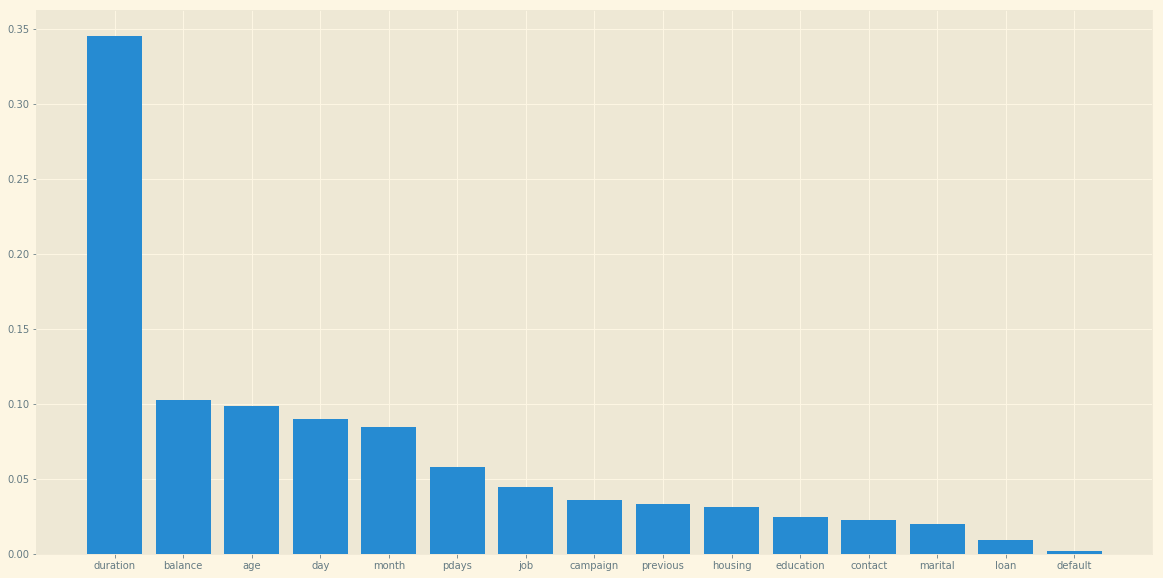

In [408]:
feature_importance = zip(X_train.columns, rdm_forest.feature_importances_)
print(sorted(rdm_forest.feature_importances_))
bar_plot = sorted(feature_importance, key=lambda x: x[1], reverse=True)
y_ticks = [y for _, y in bar_plot]
x_ticks = [x for x, _ in bar_plot]
plt.rcParams['figure.figsize'] = (20, 10)
plt.bar(x_ticks, y_ticks)
plt.plot()

### Final Model

In [497]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

trn_pipe = Pipeline([
    ("feature_drop", DataframeFeatureDrop(["poutcome"])),
    ("feature_map", DataframeFeatureMapping(**maps)),
    ("categorical_enc", DataframeCategoricalEncoding(["job", "marital", "contact"]))
])
X_train2 = trn_pipe.fit_transform(X_train)

X_train_clean, y_train_clean = remove_outliers(X_train2.values, y_train)

feat_importance_pipeline = RandomForestClassifier(max_depth=50, n_estimators=50,
                                                  random_state=42, n_jobs=-1,
                                                  max_features="sqrt")
feat_importance_pipeline.fit(X_train_clean, y_train_clean)

# pipeline = make_pipeline(
#     EditedNearestNeighbours(n_neighbors=2),
#     SelectFromModel(feat_importance_pipeline, threshold=0.01),  # 0.25
#     GradientBoostingClassifier(n_estimators=10000, learning_rate=0.042, subsample=0.4,
#                                max_features=2, random_state=42, verbose=1,
#                                max_leaf_nodes=8, max_depth=4)
# )
# pipeline = make_pipeline(
#     SMOTE(n_jobs=-1, k_neighbors=3),
#     SelectFromModel(feat_importance_pipeline, threshold=0.01),  # 0.25
#     GradientBoostingClassifier(n_estimators=10000, learning_rate=0.042, subsample=0.4,
#                                max_features=2, random_state=42, verbose=1,
#                                max_leaf_nodes=8, max_depth=4)
# )
pipeline = make_pipeline(
    SMOTE(n_jobs=-1, k_neighbors=4, random_state=45),
    SelectFromModel(feat_importance_pipeline, threshold=0.01),  # 0.25
    GradientBoostingClassifier(n_estimators=10000, learning_rate=0.042, subsample=0.4,
                               max_features=2, random_state=42, verbose=1,
                               max_leaf_nodes=8, max_depth=4)
)
# pipeline = make_pipeline(
#     SMOTE(n_jobs=-1, k_neighbors=4),
#     SelectFromModel(feat_importance_pipeline, threshold=0.025),  # 0.25
#     GradientBoostingClassifier(n_estimators=10000, learning_rate=0.045, subsample=0.4,
#                                max_features=2, random_state=42, verbose=1,
#                                max_leaf_nodes=8, max_depth=4)
# )
pipeline.fit(X_train_clean, y_train_clean)
y_pred = pipeline.predict(X_train_clean)
relative_acc = accuracy_score(y_pred, y_train_clean)
print(relative_acc)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3573           0.0288            3.70m
         2           1.3310           0.0267            3.79m
         3           1.3103           0.0204            3.84m
         4           1.2881           0.0216            3.96m
         5           1.2600           0.0281            4.09m
         6           1.2395           0.0220            4.17m
         7           1.2203           0.0167            4.20m
         8           1.2028           0.0193            4.21m
         9           1.1801           0.0210            4.24m
        10           1.1620           0.0187            4.25m
        20           0.9990           0.0154            4.30m
        30           0.8853           0.0073            4.31m
        40           0.7821           0.0108            4.32m
        50           0.7176           0.0060            4.33m
        60           0.6641           0.0042            4.29m
       

In [499]:
X_test2 = trn_pipe.transform(X_test)

y_test_pred = pipeline.predict(X_test2)
relative_acc = accuracy_score(y_test_pred, y_test)
print(relative_acc)

0.8998230871295887


## Tuning

### Grid Search

In [570]:
# from sklearn.model_selection import GridSearchCV

# params_dict = {"smote__random_state": [42], "smote__k_neighbors": [3, 4, 5],
#                "gradientboostingclassifier__n_estimators": [5000, 6500, 8000],
#                "gradientboostingclassifier__learning_rate": [0.04, 0.05]}

# gridsearch = GridSearchCV(pipeline, params_dict, scoring="accuracy", 
#                           n_jobs=-1, verbose=10)
# gridsearch.fit(X_train_clean, y_train_clean)

![](./grid_search_res.png)

In [535]:
# import pickle

# pickle.dump(gridsearch, open("./gridsearch.pickle", "wb"))

In [540]:
import pickle

gridsearch = pickle.load(open("./gridsearch.pickle", "rb"))

In [541]:
gridsearch.best_params_

{'gradientboostingclassifier__learning_rate': 0.04,
 'gradientboostingclassifier__n_estimators': 5000,
 'smote__k_neighbors': 4,
 'smote__random_state': 42}

In [533]:
y_pred = gridsearch.best_estimator_.predict(X_train_clean)
relative_acc = accuracy_score(y_pred, y_train_clean)
print("Training:", relative_acc)

X_test2 = trn_pipe.transform(X_test)
y_test_pred = gridsearch.best_estimator_.predict(X_test2)
relative_acc = accuracy_score(y_test_pred, y_test)
print("Testing:", relative_acc)

Training: 0.9422780175232117
Testing: 0.8998230871295887


In [543]:
from sklearn.metrics import classification_report

print(classification_report(list(y_test.reshape(1, -1)[0]), 
                            list(y_test_pred), target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      3968
           1       0.62      0.49      0.54       554

   micro avg       0.90      0.90      0.90      4522
   macro avg       0.77      0.72      0.74      4522
weighted avg       0.89      0.90      0.89      4522



### Bayesian Search

In [546]:
import sys
!{sys.executable} -m pip install scikit-optimize

    100% |████████████████████████████████| 81kB 6.2MB/s ta 0:00:01


In [562]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from skopt.space import Real, Integer
from skopt.utils import use_named_args

learning_rate_name = "gradientboostingclassifier__learning_rate"
space = [Real(0.02, 0.08, "log-uniform", name=learning_rate_name)]

# Model params manually set with grid search params
model = make_pipeline(
    SMOTE(n_jobs=-1, k_neighbors=4, random_state=42),
    SelectFromModel(feat_importance_pipeline, threshold=0.01),
    GradientBoostingClassifier(n_estimators=5000, subsample=0.4, 
                               max_features=2, random_state=42, 
                               verbose=1, max_leaf_nodes=8, max_depth=4)
)

@use_named_args(space)
def objective(**params):
    print(f"Choosen learning rate: {params[learning_rate_name]}")
    
    # Setting tuning params
    model.set_params(**params)
    
    # Training and Scoring
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_clean, y_train_clean,
                             cv=cv, n_jobs=-1, verbose=10)
    
    return -np.mean(scores)

In [567]:
# from skopt import gp_minimize

# res_gp = gp_minimize(objective, space, n_calls=30,
#                      random_state=0, n_jobs=-2, verbose=10)

![](./bayesian_search_res.png)

In [565]:
import pickle

pickle.dump(res_gp, open("./res_gp.pickle", "wb"))

[]

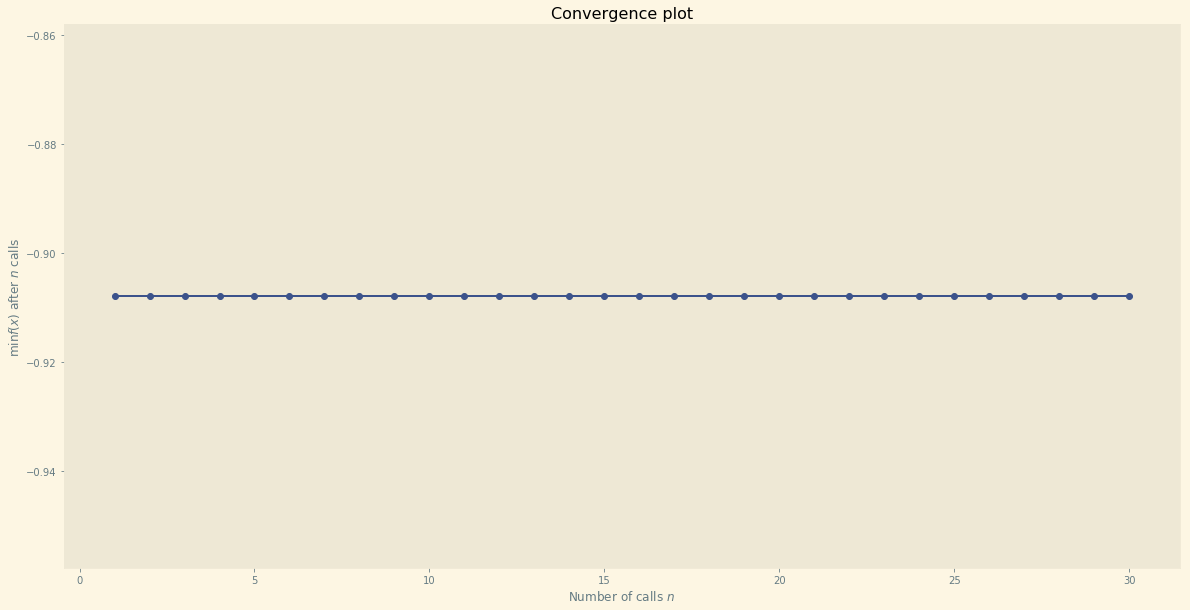

In [566]:
from skopt.plots import plot_convergence

res_gp = pickle.load(open("./res_gp.pickle", "rb"))

plot_convergence(res_gp)
plt.plot()

## Final Evaluation

## References